# AC209B Final Project
## Module E: Predicting COVID-19 Cases
- Austin Rochon
- Emily Xie
- Mark Lock

<hr style="height:2pt">

## Table of Contents

- [Introduction](#introduction)
- [Data Summary](#data_summary) 
- [Exploratory Data Analysis](#eda) 
- [Model Selection and Architecture](#model_selection)
- [Results](#results)
- [Appendix I: Data Collection and Cleaning](#data_collection)  
    - [COVID-19 Cases by State](#us_state_covid)  
    - [Google Search Data](#google_search)  
    - [Google Community Mobility Reports](#google_mobility)  
    - [IHME Social Distancing Data](#ihme_social_distancing)
    - [Weather](#weather)
- [Appendix 2: RNN data prep, build, train, prediction](#rnn)
    
 

<a id='introduction'></a>
## Introduction
***

In late 2019, a highly infectious novel coronavirus (SARS-CoV-2) emerged in the city of Wuhan, China. Within weeks, the virus and the disease it causes (COVID-19) had spread to multiple countries. On March 11, 2020, the World Health Organization officially declared the COVID-19 outbreak a pandemic, and as of the end of April 2020, there were over 3 million COVID-19 cases worldwide across over 200 countries and territories.

This project focuses on the impact of COVID-19 in the United States. In particular, we use a combination of Google search and mobility data, weather data, hospitalization and ICU numbers, and the dates in which state social distancing measures took effect to predict state-level COVID-19 cases in the US.

In [2]:
import pandas as pd
import pickle
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


<a id='data_summary'></a>
## Data Summary
***

For our response, we used a state-by-state COVID-19 cases dataset, curated by the New York times:
- **[COVID-19 Cases by State (Response)](https://github.com/nytimes/covid-19-data):** The NYT publishes national, state-level, and county-level COVID-19 case data to their github repository daily

To make predictions, we leveraged the following predictor data:
- **[Google Trends Search Data](https://trends.google.com/trends/?geo=US):** Through the Google Trends API, we collected search query data related to the coronavirus, and focused in particular on coronavirus symptom-based searches
- **[Google Community Mobility Reports](https://www.google.com/covid19/mobility/data_documentation.html?hl=en):** In March of 2020, Google began publishing "Community Mobility Reports", which tracked changes in activity from a pre-coronavirus baseline to now for countries across the world. It built these reports by collecting the location data tied to cell phones. In particular, it tracked changes in mobility for the following six categories: 
    - Retail & recreation
    - Grocery & pharmacy
    - Parks
    - Transit stations
    - Workplaces
    - Residential
- **[State Social Distancing Measures](http://www.healthdata.org/covid/faqs#social%20distancing):** The University of Washington's Institute for Health Metrics and Evaluation (IHME) has produced one of the most famous COVID-19 models. As part of its modeling, it incorporates state-wide social distancing measures. We've leveraged their data to determine whether and when a state put in place the following the following measures:
    - Educational facilities closed
    - Non-essential businesses ordered to close
    - People ordered to stay at home
    - Severe travel restrictions
    - Any gathering restrictions
    - Any business closures
- **[Hospitalization and ICU Data](https://covidtracking.com/data):** The Covid Tracking Project monitors hospitalization and ICU numbers for the states that report them. However, a big caveat for this data is that many states do not report these numbers
- **[Weather Data](https://www.ncdc.noaa.gov/cdo-web/datatools/lcd):** The US National Oceanic and Atmospheric Association (NOAA) collects local climatological data for weather stations across the United States. We scraped this data to get temperature and humidity readings for all states in the US.



<a id='eda'></a>
## Exploratory Data Analysis
***
**US Cases by State**

In our initial EDA, we generated a bubble plot of the US, displaying states that were especially hard hit by COVID-19 (New York, Louisiana, and New Jersey), in terms of cases per capita. Rerunning our code depicts a grimmer picture, with new states such as Michigan and Illinois joining the originally hard hit ones.

In [70]:
from IPython.display import IFrame

IFrame(src='./images/US_covid_map.html', width=700, height=600)

**Coronavirus-Related Queries**

We began by investigating coronavirus-related Google searches. In particular, we sought to examine whether the following queries were associated with spikes in new cases:
- 'flu'
- 'shortness of breath'
- 'loss of smell'
- 'loss of taste'
- 'cough'
- 'fever'
- 'coronavirus testing near me'
- 'do i have coronavirus'
- 'covid testing center'
- 'chills'
- 'sore throat'
- 'fatigue'
- 'chest pain'

In [89]:
# load query data
queries = pickle.load( open( "./data/us_state_queries.p", "rb" ) )

# load case data
cases = pickle.load( open( "./data/us_state_cases_deaths.p", "rb" ) )

First, focusing on New York state, we can see how google search trends compare to the rise in COVID cases

In [118]:
# queries
s = "NY"
kw_list = list(queries.drop(["date", "abbrev", "days_since_20200101"], axis=1).columns)
s_queries = queries.loc[queries["abbrev"] == s]

# cases
s_cases = cases.loc[cases["abbrev"] == s]
s_cases["new_cases"] = s_cases["cases"].diff()

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


First, let's look at the 4 queries with the highest volume

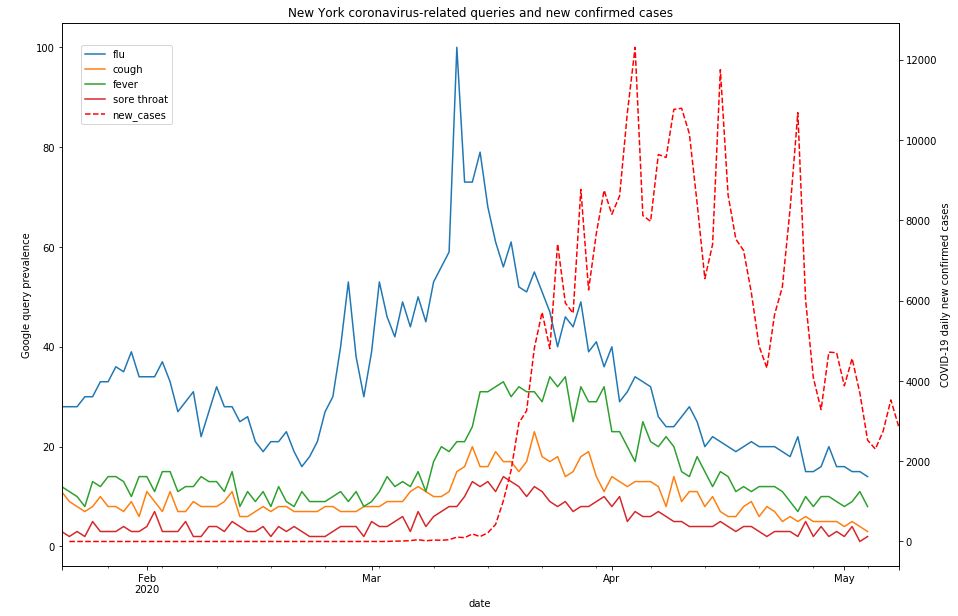

In [124]:
# now plot queries with confirmed cases
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)

# queries
s_queries.plot(x="date", y=kw_list[0],  ax=ax1, legend=False)
s_queries.plot(x="date", y=kw_list[4],  ax=ax1, legend=False)
s_queries.plot(x="date", y=kw_list[5],  ax=ax1, legend=False)
s_queries.plot(x="date", y=kw_list[10],  ax=ax1, legend=False)

ax2 = ax1.twinx()

# new cases
s_cases.plot(x="date", y="new_cases", ax=ax2, legend=False, color="r", linestyle='dashed')

# legend and titles
ax1.figure.legend(loc="upper left", bbox_to_anchor=(0.07,0.80))
ax1.set_title("New York coronavirus-related queries and new confirmed cases")
ax1.set_ylabel("Google query prevalence")
ax2.set_ylabel("COVID-19 daily new confirmed cases")
fig.savefig('./images/NY_covid_queries.png', format='png', dpi=300)
plt.show();

Now the next few. We won't plot them all because the charts get extremely noisy with many queries.

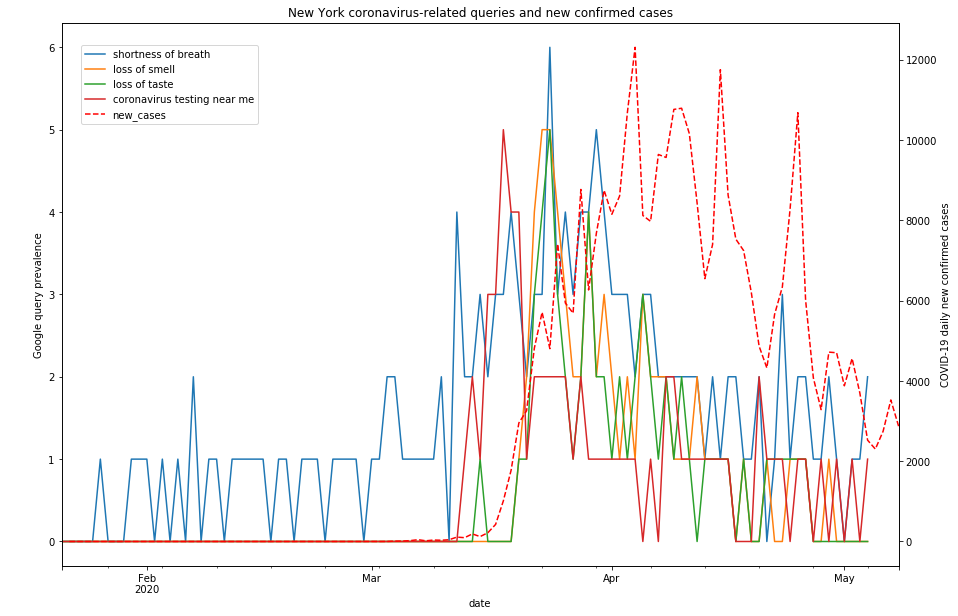

In [121]:
# now plot queries with confirmed cases
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)

# queries
s_queries.plot(x="date", y=kw_list[1],  ax=ax1, legend=False)
s_queries.plot(x="date", y=kw_list[2],  ax=ax1, legend=False)
s_queries.plot(x="date", y=kw_list[3],  ax=ax1, legend=False)
s_queries.plot(x="date", y=kw_list[6],  ax=ax1, legend=False)

ax2 = ax1.twinx()

# new cases
s_cases.plot(x="date", y="new_cases", ax=ax2, legend=False, color="r", linestyle='dashed')

# legend and titles
ax1.figure.legend(loc="upper left", bbox_to_anchor=(0.07,0.80))
ax1.set_title("New York coronavirus-related queries and new confirmed cases")
ax1.set_ylabel("Google query prevalence")
ax2.set_ylabel("COVID-19 daily new confirmed cases")
plt.show();

**Community Reports**

We also looked at community mobility reports. It might be worth looking at how mobility has changed over time since our initial EDA. As we can see below, after the precipitous drop in early April, retail and recreation have begun to slightly increase again, especially in Georgia, which, on May 1st, canceled its stay at home order. A similar trend is present in transit stations and workplaces.

In [67]:
# load mobility reports
mobility_us = pickle.load( open( "./data/us_state_mobility_data.p", "rb" ) )
mobility_us.head()

,date,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,abbrev,days_since_20200101
94913,2020-02-15,United States,6.0,2.0,15.0,3.0,2.0,-1.0,USA,45
94914,2020-02-16,United States,7.0,1.0,16.0,2.0,0.0,-1.0,USA,46
94915,2020-02-17,United States,6.0,0.0,28.0,-9.0,-24.0,5.0,USA,47
94916,2020-02-18,United States,0.0,-1.0,6.0,1.0,0.0,1.0,USA,48
94917,2020-02-19,United States,2.0,0.0,8.0,1.0,1.0,0.0,USA,49


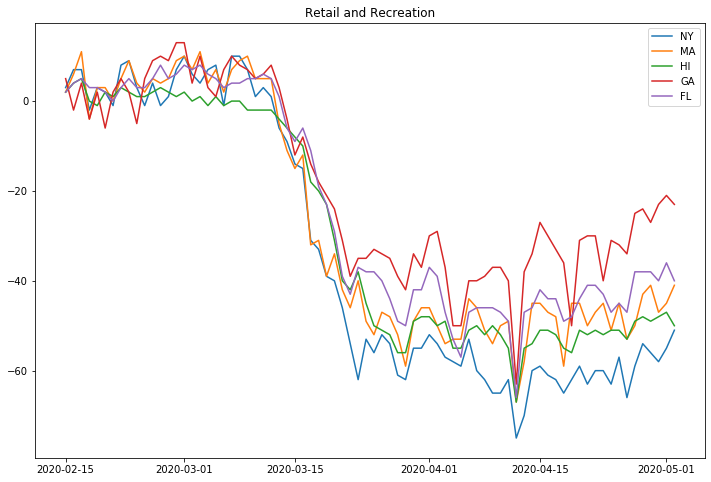

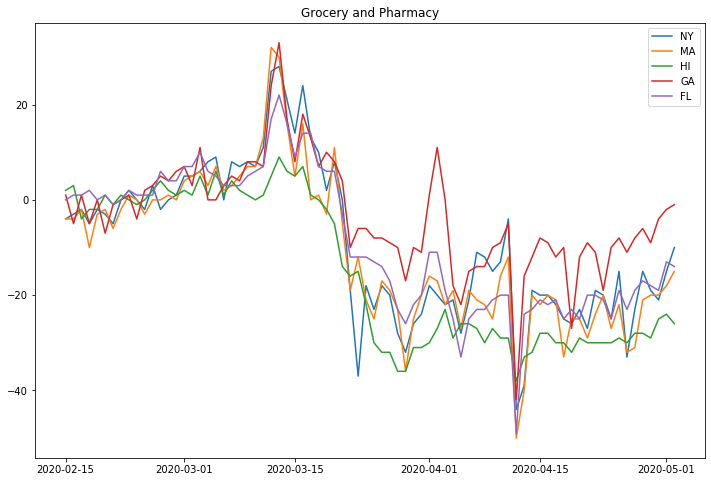

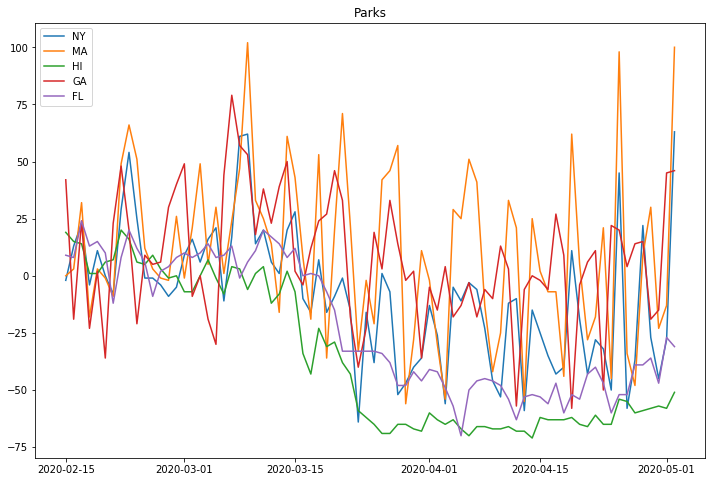

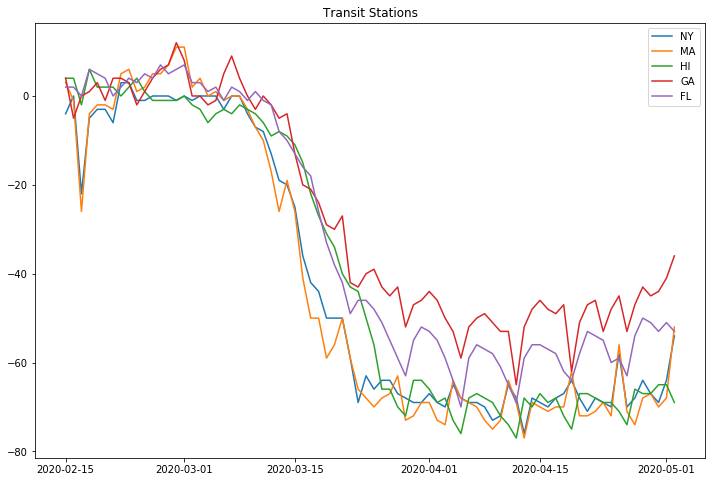

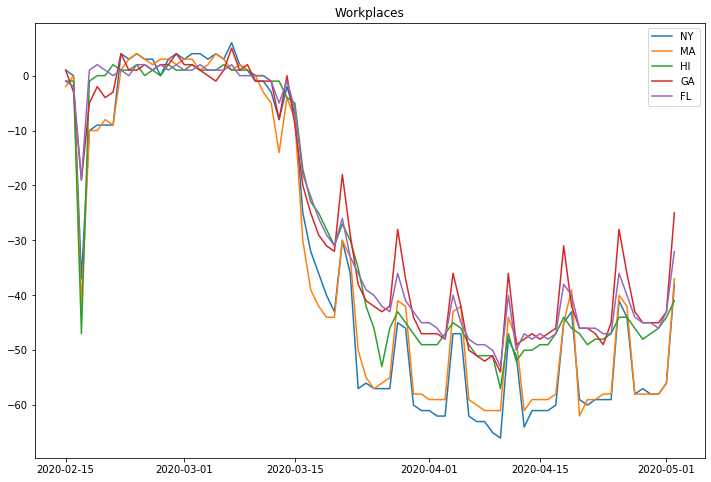

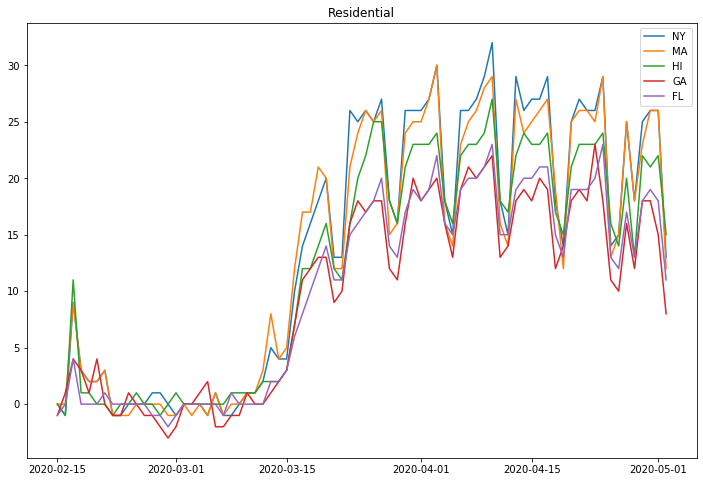

In [69]:
# subset of a few states
states = ["NY", "MA", "HI", "GA", "FL"]
mobility_sub = mobility_us.loc[mobility_us["abbrev"].isin(states)]


# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "retail_and_recreation_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Retail and Recreation")
    plt.legend();
    
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "grocery_and_pharmacy_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Grocery and Pharmacy")
    plt.legend();
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "parks_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Parks")
    plt.legend();
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "transit_stations_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Transit Stations")
    plt.legend();
    
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "workplaces_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Workplaces")
    plt.legend();
    
# plot
fig, ax = plt.subplots(figsize=(12, 8))

for state in states:
    plt.plot("date", "residential_percent_change_from_baseline", 
             data=mobility_sub.loc[mobility_sub["abbrev"] == state], label=state)
    plt.title("Residential")
    plt.legend();

**Weather**

We wanted to explore weather as a potential predictor, due to the speculation that the SARS-COV-2 virus becomes less viable for transmission in climates with high humidity and temperature. Below, we'll take a quick look at the weather data, and also perform a small amount of EDA on it.

In [39]:
# Import the response variable to perform EDA against.
response = pickle.load(open("./data/us_state_cases_deaths.p", "rb"))
response.head()

,date,state,fips,cases,deaths,abbrev,days_since_20200101
0,2020-01-21,Alabama,1,0,0,AL,20
1,2020-01-22,Alabama,1,0,0,AL,21
2,2020-01-23,Alabama,1,0,0,AL,22
3,2020-01-24,Alabama,1,0,0,AL,23
4,2020-01-25,Alabama,1,0,0,AL,24


In [40]:
weather_df = pickle.load(open("./data/daily_average_temp_by_state.p", "rb")) 
weather_df.head()

,state,date,average_temperature,abbrev,average_humidity,days_since_20200101
0,Alaska,2020-01-01,21.271028,AK,79.766355,0
1,Alaska,2020-01-02,12.590909,AK,80.386364,1
2,Alaska,2020-01-03,11.866667,AK,83.986667,2
3,Alaska,2020-01-04,14.600000,AK,85.381818,3
4,Alaska,2020-01-05,10.089286,AK,78.035714,4


First, we'll generate a quick plot of the average temperatures across a few states just to get a sense of what the data looks like.

Text(0.5, 1.0, 'Average Temperatures of States Since 1/1/2020')

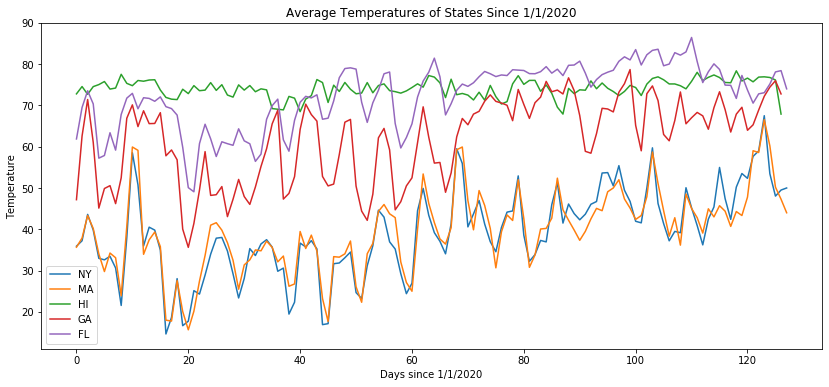

In [41]:
plt.figure(figsize=(14, 6))
states = ["NY", "MA", "HI", "GA", "FL"]
for abbrev in states:
    average_temps = weather_df[weather_df["abbrev"] == abbrev]["average_temperature"]
    plt.plot(range(len(average_temps)), average_temps, label=abbrev)
    
plt.legend()
plt.xlabel("Days since 1/1/2020")
plt.ylabel("Temperature")
plt.title("Average Temperatures of States Since 1/1/2020")

The data is sensible from what we know; states like Florida and Georgia remain hot throughout the year, whereas New York and Massachusetts track a similar temperature pattern.

For EDA, we wanted to determine if there are any correlations between temperature + humidity and deaths in order to get a sense of the viability of weather as a predictor. 

Deaths seemed a more reliable statistic here are states are likely to report deaths, but many cases go unreported. However, given how varied states are in population, a sheer count of deaths would provide a skewed metric when comparing across states. Thus, we'll look at the percentages of COVID-19 deaths in a state's population. This will provide a fairer comparison against each state. 

For this, we will import estimated 2019 population data for each state from census.gov:  
https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html#par_textimage_1574439295

In [42]:
import numpy as np
states_population_data = pd.read_csv("data/states_2019_estimated_population.csv")
states_population_data["population"] = states_population_data["population"].apply(lambda x: np.int64(x.replace(",", "")))
states_population_data.head()

,state,population
0,Alabama,4903185
1,Alaska,731545
2,Arizona,7278717
3,Arkansas,3017804
4,California,39512223


In [43]:
# Merge reponse and weather data into one PD for ease of use.
weather_cases = weather_df.merge(
    response, 
    left_on=["abbrev", "date"], 
    right_on=["abbrev", "date"]
).rename(
    columns={"state_x": "state", "days_since_20200101_x": "days_since_20200101"}
).drop(columns=["state_y", "days_since_20200101_y"]).merge(
    states_population_data,
    left_on="state",
    right_on="state",
).dropna(subset=["average_humidity"])
weather_cases.head()

,state,date,average_temperature,abbrev,average_humidity,days_since_20200101,fips,cases,deaths,population
0,Alaska,2020-01-21,19.189873,AK,81.683544,20,2,0,0,731545
1,Alaska,2020-01-22,23.761194,AK,77.701493,21,2,0,0,731545
2,Alaska,2020-01-23,24.463415,AK,83.573171,22,2,0,0,731545
3,Alaska,2020-01-24,19.745763,AK,84.627119,23,2,0,0,731545
4,Alaska,2020-01-25,21.985507,AK,82.072464,24,2,0,0,731545


Now, let's group by each state, and order them based on their weighted temperature + humidity scores.

In [145]:
response_states = response["abbrev"].unique()

states_by_avg_temp = weather_cases.groupby(["state"]).agg({
    "state": "first",
    "average_temperature": "mean", 
    "average_humidity": "mean",
    "abbrev": "first",
    "cases": "max", # Since these figures are cumulative, just grab the largest
    "deaths": "max",
    "population": "max",
}).reset_index(drop=True)
states_by_avg_temp["weighted_humidity_temp"] = (
    states_by_avg_temp["average_temperature"] * .80) + (states_by_avg_temp["average_humidity"] * .20
)

states_by_avg_temp = states_by_avg_temp.sort_values(by=["weighted_humidity_temp"], ascending=True)
states_by_avg_temp["deaths_percent"] = (states_by_avg_temp["deaths"] / states_by_avg_temp["population"])* 100

response_states_avg_temp = [x for x in states_by_avg_temp["abbrev"] if x in response_states]
    
coldest_states = response_states_avg_temp[0:5]
hottest_states = response_states_avg_temp[-6:-1]


We've added an extra column called `weighted_humidity_temp` in which we create a weighted sum of humidity (20%) and temperature (80%). We noted that in a lot of places, humidity is highly varied from day to day, and so we decided to give it less weight in our asssessments. We sort the states in decreasing order of this metric.

Let's take a look at some of the raw numbers of the most and least humid + hot states to begin with:

In [146]:
print("Most Hot and Humid States:")
display_cols = ["state", "abbrev", "average_humidity", "average_temperature", "deaths_percent"]
display(states_by_avg_temp[display_cols][states_by_avg_temp["abbrev"].isin(hottest_states)])

print("Least Hot and Humid States:")
display(states_by_avg_temp[display_cols][states_by_avg_temp["abbrev"].isin(coldest_states)])

Most Hot and Humid States:


,state,abbrev,average_humidity,average_temperature,deaths_percent
0,Alabama,AL,74.104596,57.538420,0.006995
8,Georgia,GA,71.490446,62.452800,0.012329
15,Louisiana,LA,75.994593,64.211541,0.045926
21,Mississippi,MS,70.883702,66.229402,0.012567
7,Florida,FL,67.579157,73.387513,0.007445


Least Hot and Humid States:


,state,abbrev,average_humidity,average_temperature,deaths_percent
44,Wyoming,WY,74.306096,22.949677,0.001209
20,Minnesota,MN,67.469115,26.987992,0.009008
1,Alaska,AK,71.807716,28.456035,0.001094
25,New Hampshire,NH,68.413081,30.356930,0.008384
43,Wisconsin,WI,74.712823,28.842833,0.006423


Certainly, just looking at the raw percentage of deaths in the warmest, most humid states vs the coldest, most arid states, there certainly appears to be a pattern. 

We can confirm this by plotting all of the states and death percentages, where each bar represents a state.

In [197]:
states_by_avg_temp["abbrev"].values

array(['WY', 'MN', 'AK', 'NH', 'WI', 'ND', 'VT', 'MT', 'ME', 'CO', 'NY',
       'MA', 'IA', 'NE', 'MI', 'CT', 'NJ', 'OH', 'RI', 'PA', 'IN', 'WV',
       'MD', 'IL', 'NM', 'WA', 'DE', 'VA', 'MO', 'KY', 'OR', 'KS', 'TN',
       'NC', 'OK', 'TX', 'CA', 'AZ', 'SC', 'AL', 'GA', 'LA', 'MS', 'FL',
       'HI'], dtype=object)

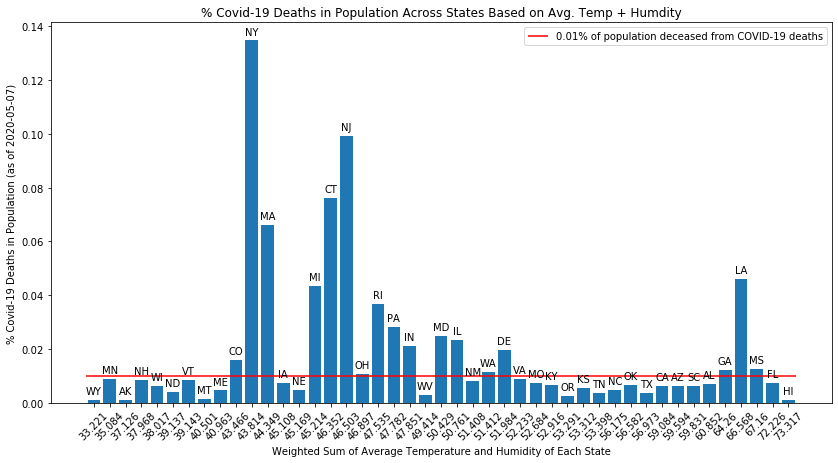

In [207]:
percent_covid_deaths = states_by_avg_temp["deaths_percent"]
weighted_ht = states_by_avg_temp["weighted_humidity_temp"]

wht_str = states_by_avg_temp["weighted_humidity_temp"].round(3).astype(str)
states_names = states_by_avg_temp["abbrev"].values

x = wht_str + " " + states_names
max_date = weather_cases["date"].max().date()

fig, ax = plt.subplots(figsize=(14, 7))

ax.tick_params(axis='x', labelrotation=45)
rects1 = ax.bar(wht_str, percent_covid_deaths)

ax.set_title("% Covid-19 Deaths in Population Across States Based on Avg. Temp + Humdity")
ax.set_xlabel("Weighted Sum of Average Temperature and Humidity of Each State")
ax.set_ylabel(f"% Covid-19 Deaths in Population (as of {max_date})")
ax.hlines(y=0.01, xmin=-0.5, xmax=44.5, color="red", label="0.01% of population deceased from COVID-19 deaths")
ax.legend()

# Citation - Bar chart code for labeling
# from official documentation: 
# https://matplotlib.org/examples/api/barchart_demo.html
def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for i, rect in enumerate(rects):
        height = rect.get_height()
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                states_names[i],
                ha='center', va='bottom')

autolabel(rects1, ax)

In the plot above, each bar represents a state, arranged from lowest humidity / temperature to highest. We draw a line at 0.01% population death from COVID-19. A trend is certainly noticeable here; death rates appear to be higher for the drier / more arid states. We'll notice that the left half of the plot entails markedly more states with a death rates greater than 0.01%.

While there are certainly other variables at play (perhaps there are more dense urban centers in colder climates within the US), there appears to be a noticeable relationship between higher percentages of cumulative deaths from COVID-19 in the population, and a drier / colder climate. Thus, in our early EDA, we suspected that this would be a viable candidate for a predictor.

<a id='model_selection'></a>
## Model Selection and Architecture
***

# GRU Encoder-Decoder + Bahdanau Attention

The inspiration of this approach was the Google's wait time search cards. This team aims to predict wait times/ busy-ness at restaurants based on query and mobility data. 

What if we could do the same with COVID cases by state using the same type of data?

The beauty of this approach is a highly dynamic windowed forecast. The Google wait time search card updates about once a week. In the same way, we can think about forecasting COVID cases with a short but not too short window - 7 day look back and about half a window looking forward (3 days).




In [747]:
from IPython.display import Image
Image(url='https://www.howtogeek.com/wp-content/uploads/2020/04/google-maps-popular-times-on-iphone.png')

We took our inspiration from seq-2-seq models where we have a known sequence looking to predict another sequence. This is most often done in the context of machne translations. We also took inspiration from a paper by Ebesu and Fang (2017) in which the authors did not utilize word tokens in their seq 2 seq model but actually used disparate sources of data to form a hidden representation of all of their features (convolved author and citation context representations) for encoding. What they decoded were citation titles.

How is this different from a traditional seq-2-seq model? In a translation context you have words being encoded and words being decoded. The decoded sequence data types (cases) are different from the encoding sequence data (queries+mobility+cases+state). This is quite like what Ebesu and Fang did. They concatenated all feature outputs from the encoders of these different data types and concatenated into one hidden state tensor in which to feed the decoder at time step 0.

What is also unique is the windowed approach to forecasting. Since forecasting is not a static exercise, we can forget older pieces of information and add on new pieces of information everyday to make forecasts. We wanted to make a forecast mechanism that could forecast given a certain time window or context, as termed in the NLP world, (7 days of data) regardless of where this window falls in the year. Therefore we try to abstract away absolute date out of the modeling. This model then answers the question: Is there a model that is time-point invariant but time-context variant?



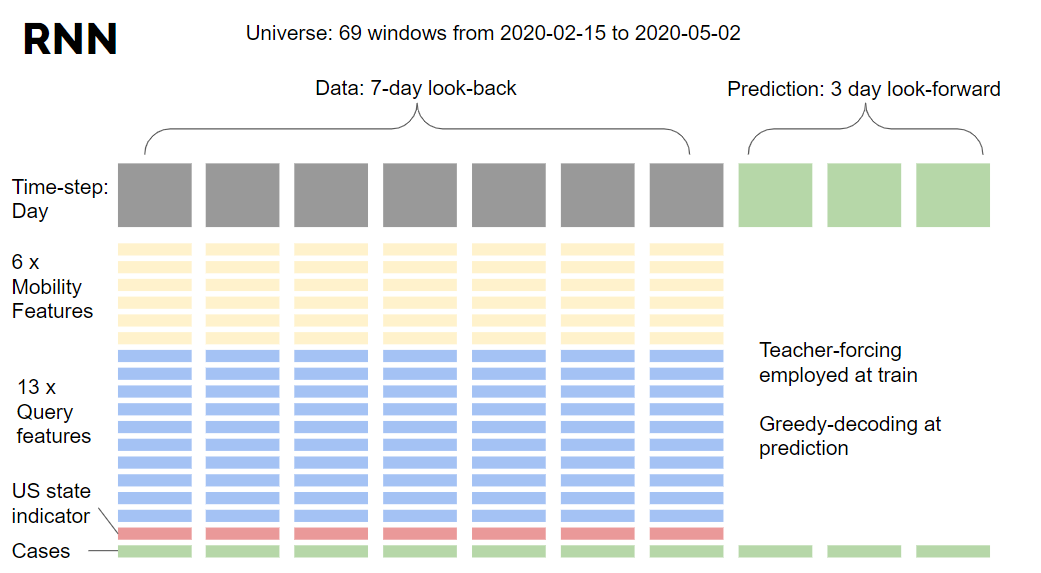

In [751]:
from IPython.display import Image
Image(filename='../content/Capture.PNG')

Our data methodology was as follows:

We sequence data such that there are the following arrays:

For each state and each time window

*   queries encode (13 features)
*   cases encode (1 feature)
*   mobility encode (6 features)
*   cases decode (TARGET)

Then create train (90%) and test indices (10%). No need for val indices since we're not doing anything like early stopping.

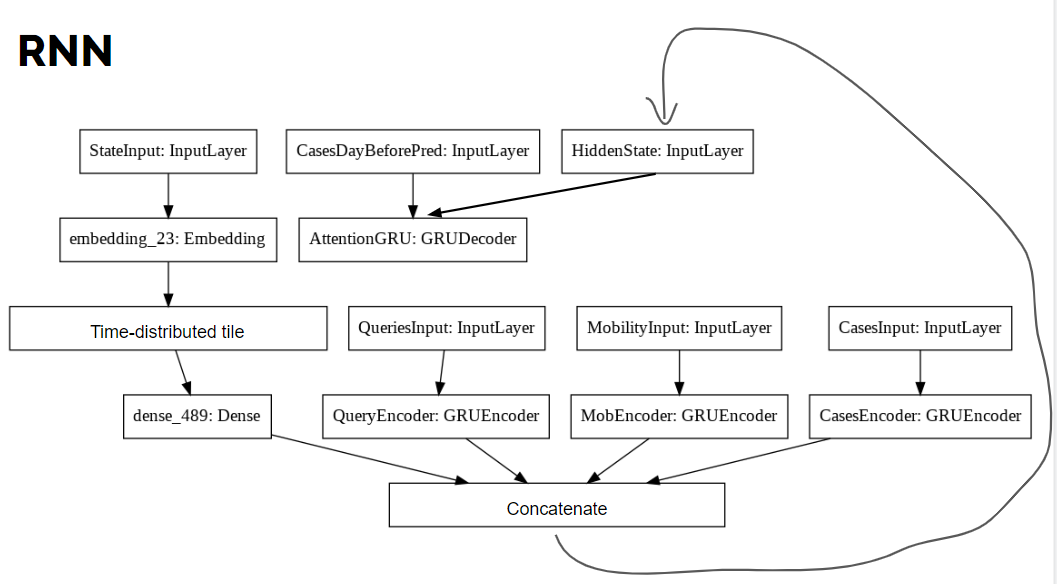

In [752]:
from IPython.display import Image
Image(filename='../content/Capture.PNG')

The architecture of the network was as follows:

Enconding
* Encode all query features through a single layer GRU and output in 128 embedding space.
* Encode all mobility features through a single layer GRU and output in 128 embedding space.
* Encode the cases vector through a single layer GRU and output in 128 embedding space.
* Encode the state indicator (data was at a state level) by time-distribute tiling across encoder time-steps. You will then get a tensor of the same state embedding across all encoding timesteps. Then  output in 128 embedding space. The reason we do this is so the output dimensions match with the time-variant features above so we can easily concat later.
* Concatenate the 4 encoded outputs above on the last axis. We can think of the last axis as the number of filters (in an imaging context) or the embedding size (in a language context). Either way, we use this 512 size embedding as an input into the hidden state of the GRU decode.

Decoding
* **GRU:** We employ 3 layers here. The idea was that there qualitatively are 3 types of decoded sequences - pre-corona outbreak which tend to be steady and low, the first few days of the initial outbreak which shows some sort of discontinuity or high acceleration and then the leveling off at later windows. We hoped that employing three PARALLEL (NOT DEEP) layers which were then densely combined would allow the network to learn this distinction, which it seems it did from the plots.
* **Attention:** We put together a custom implementation of Bahdanau attention which is used to help align the decoder's ith time step with the jth timestep in the encoder hidden outputs. Think of this as a weighted average of the encoding output but authomatically learned through backprop. Bahdanau is additive attention (rather than multiplicative like Luong) which means we concatenate the context vectors from the attention mechanism and then reduce the final output using a projection back into the output space. Bahdanau has empirically worked better for me than Luong attention. Attention also makes it possible to interpret which timestep the algorithm is paying attention to at any given decode timestep.

Experiments that failed:
* **Parallel gradient updates:** Super-charge state conditioning by creating an auxiliary regressor with its own loss a la inception style. We trained the network mentioned abovew in concert with a network that shared the state encoder and simply predicted from a single layer GRU the cases. We used two gradient tapes to track gradients for the two networks and at each batch we updated the affected variables based on their own losses. This DID NOT WORK well, because the network learned TOO fast and exploited loopholes like learning how to predict all zeros for certain states to drive down MSE.
* **Joint gradient updates:** We tried to ensemble the state-only decode-encode netowrk and the original network using a dense layer as mediator. This worked the worst as it could not converge. This might have been due to the fact that the original network relied on the state encoder which was shared by the two networks. This caused highly correlative dependencies in weights resulting in no clear optima.

Now on to results of our model proposed above.

<a id='results'></a>
## Results
***

The main finding was that the network was pretty good at modeling the forecast for a 7 day look back and 3 day look forward FOR MOST STATES. However any states that had windows with cases that were ABOVE the maximum number of cases seen in the train data, had a lot of prediction error. The model overfitted and couldn't really predict above this max value (33,037).

This is best illustrated with examples and a table. The table is sorted from lowest to highest RMSE. The RMSE increased drastically for any states that had higher than 33,037 cases.


* Test RMSE: 25,000, range of test data: 0 to 315,000
* Test RMSE is order of magnitude lower than range of cases
* RMSE is largely driven by outlier states NY, NJ, MA, etc., of which some outlier time points are not even present in the train data. Had issues predicting anything above maximum of seen data.


In [0]:
rmse_list = []
max_true = []
max_pred = []
min_true = []
min_pred = []
states = []
for state in state_list:
  tups = get_state_tups(queries_sequences, mobility_sequences, cases_sequences, state_df_list, state)
  e, target, predictions, attention_plots= evaluate_states(tups)
  target = np.array(target).flatten()
  predictions = np.array(predictions).flatten()
  rmse_list += [np.mean(tf.keras.losses.MSE(target, predictions))**0.5]
  max_true += [np.max(target)]
  max_pred += [int(np.max(predictions))]
  min_true += [np.min(target)]
  min_pred += [int(np.min(predictions))]
  states += [state]

display_df = pd.DataFrame({'state': states,\
              'rmse': rmse_list,\
              'max_true': max_true,\
              'max_pred': max_pred,\
              'min_true': min_true,\
              'min_pred': min_pred})
display_df.sort_values(by='rmse', ascending=True)

,state,rmse,max_true,max_pred,min_true,min_pred
21,MT,20.733586,454,464,0,0
44,HI,25.681209,611,624,0,0
38,WY,29.614746,579,563,0,0
26,AK,41.477401,363,464,0,0
13,ND,44.263770,1153,1219,0,0
43,ME,52.329497,1152,1275,0,0
6,WV,53.266120,1184,1264,0,0
18,VT,54.347825,886,1124,0,0
45,NH,178.466476,2429,2581,0,0
20,UT,200.603718,4981,4548,0,0


TN predictions given 7-day look-back and 3-day look-forward
GREY:true, BLUE:prediction


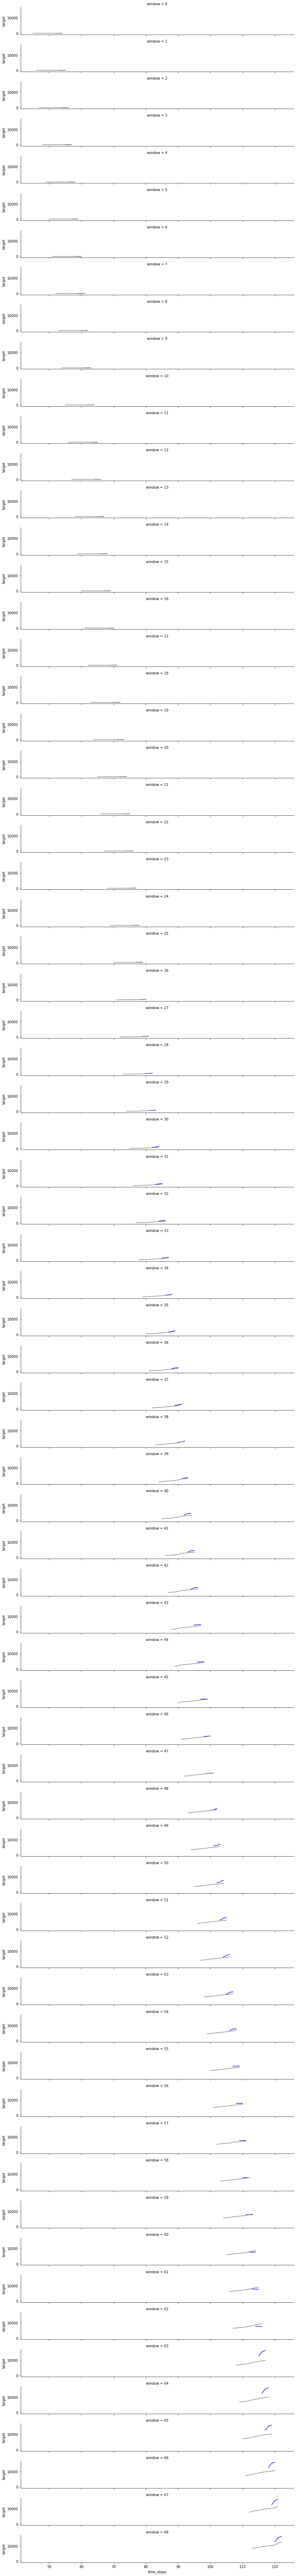

In [0]:
# TN predictions plot
import matplotlib.pyplot as plt
import seaborn as sns

print('TN predictions given 7-day look-back and 3-day look-forward\nGREY:true, BLUE:prediction')
g = sns.FacetGrid(tn_plot_df, row="window", height=1.5, aspect=8, sharex=True)
g = g.map(plt.plot, "time_steps", "pred", color='blue')
g = g.map(plt.plot, "time_steps", "target", color='gray');

MA predictions given 7-day look-back and 3-day look-forward
GREY:true, BLUE:prediction


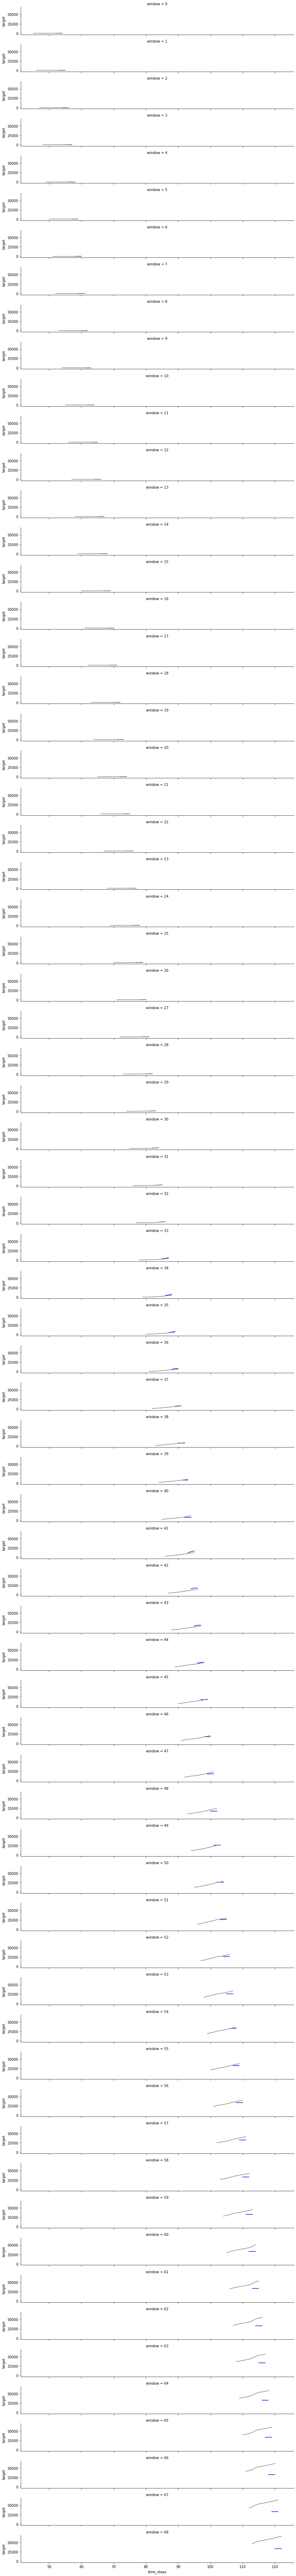

In [0]:
# MA predictions plot
import matplotlib.pyplot as plt
import seaborn as sns

print('MA predictions given 7-day look-back and 3-day look-forward\nGREY:true, BLUE:prediction')
g = sns.FacetGrid(ma_plot_df, row="window", height=1.5, aspect=8, sharex=True)
g = g.map(plt.plot, "time_steps", "pred", color='blue')
g = g.map(plt.plot, "time_steps", "target", color='gray');

## Interpreting performance

* Attention plots showed us how the decoder is predicting off of the last 7 days!
* **The 1st prediction timestep:** setting a baseline so the decoder paid attention to timestep 0 in the encoder sequence
* **The 2nd and 3rd prediction timesteps:** knowing how much to increase off of the baseline, thus focused on the latter half of the encoder sequence to assess change over time.



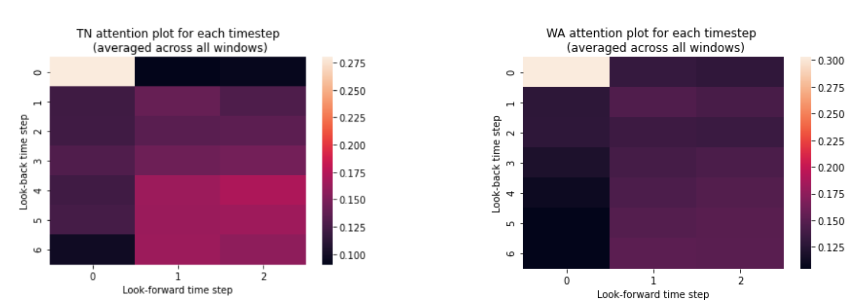

In [753]:
from IPython.display import Image
Image(filename='../content/Capture.PNG')

<a id='data_collection'></a>
## Appendix I: Data Collection and Cleaning
***

<a id='us_state_covid'></a>
### COVID-19 Cases by State
We'll start by fetching and cleaning our response data: COVID-19 cases by state

In [11]:
# fetch US state data from the NY Times github
covid_us = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")

# fetch US totals data and match formatting
covid_us_totals = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv")
covid_us_totals["state"] = "United States"
covid_us_totals["fips"] = 0
covid_us_totals = covid_us_totals[["date", "state", "fips", "cases", "deaths"]]

# merge two dfs
covid_us = pd.concat([covid_us, covid_us_totals])

# transform date to datetime object
covid_us["date"] = pd.to_datetime(covid_us["date"])

covid_us

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
104,2020-05-04,United States,0,1186979,68843
105,2020-05-05,United States,0,1210686,71077
106,2020-05-06,United States,0,1235190,73785
107,2020-05-07,United States,0,1264001,75744


In [33]:
def impute_missing_dates(df):
    '''
    function that imputes cases and deaths data for missing 
    dates with 0. returned df should have same MIN_DATE and 
    MAX_DATE for all states.
    '''
    # set min values
    MIN_DATE = df["date"].min()
    MIN_CASES = 0
    MIN_DEATHS = 0
    
    # iterate through all states
    imputed_data = []    
    for state in df["state"].unique():
        # build list of missing dates
        # https://stackoverflow.com/questions/7274267/print-all-day-dates-between-two-dates
        sdate = MIN_DATE
        edate = df.loc[df["state"] == state]["date"].min()
        delta = edate - sdate 

        # iterate through all missing dates and impute case and 
        # death data
        for i in range(delta.days):
            day = sdate + datetime.timedelta(days=i)
            imputed_data.append({"date": day,
                                 "state": state,
                                 "fips": df.loc[df["state"]==state].iloc[0]["fips"],
                                 "cases": MIN_CASES,
                                 "deaths": MIN_DEATHS})

    # final cleanup
    new_df = pd.concat([pd.DataFrame(imputed_data), df])
    new_df = new_df.sort_values(by=["state", "date"]).reset_index().drop("index", axis=1)
    
    return new_df
    

def days_since_20200101(df):
    '''
    Creates a new column which measures the number of days that 
    a given observation is from 20200101 (which will be our 
    baseline date)
    '''
    # create days_since_20200101 col
    START_DATE = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d")
    df["days_since_20200101"] = (df["date"] - START_DATE).dt.days
    
    return df
    
    
# map state abbreviation
states_dict = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'United States': 'USA'
}

states = list(states_dict.values())

In [13]:
# clean data by imputing missing dates and mapping abbreviations
covid_us_cleaned = impute_missing_dates(covid_us)
covid_us_cleaned["abbrev"] = covid_us_cleaned["state"].map(states_dict)

# create days_since_20200101 col
covid_us_cleaned = days_since_20200101(covid_us_cleaned)
covid_us_cleaned

,date,state,fips,cases,deaths,abbrev,days_since_20200101
0,2020-01-21,Alabama,1,0,0,AL,20
1,2020-01-22,Alabama,1,0,0,AL,21
2,2020-01-23,Alabama,1,0,0,AL,22
3,2020-01-24,Alabama,1,0,0,AL,23
4,2020-01-25,Alabama,1,0,0,AL,24
...,...,...,...,...,...,...,...
6099,2020-05-04,Wyoming,56,596,7,WY,124
6100,2020-05-05,Wyoming,56,604,7,WY,125
6101,2020-05-06,Wyoming,56,631,7,WY,126
6102,2020-05-07,Wyoming,56,635,7,WY,127


<a id='google_search'></a>
### Google COVID-19 Searches

Next, we collected Google search data related to COVID-19. We started by curating a list of Google search queries that we thought could be predictive of coronavirus cases. To extract the Google query data, we used [pytrends](https://github.com/GeneralMills/pytrends) a library that allows you to query the GoogleTrends API for search data.

In [14]:
import pytrends
from pytrends.request import TrendReq

# connect 
pyt = TrendReq(hl='en-US', tz=300)

We started by fetching a list of queries related to "coronavirus symptoms"

In [15]:
kw_list = ["coronavirus symptoms"]
now = datetime.datetime.now().strftime("%Y-%m-%d")
time_frame = f'''2020-01-01 {now}'''
pyt.build_payload(kw_list, cat=0, timeframe=time_frame, geo='US', gprop='')
pyt.related_queries()[kw_list[0]]["rising"]

,query,value
0,the coronavirus,989350
1,the symptoms of the coronavirus,675550
2,the symptoms of coronavirus,663400
3,corona symptoms,490450
4,corona,488550
5,what are coronavirus symptoms,413900
6,corona virus,354150
7,corona virus symptoms,345900
8,what are symptoms of coronavirus,343550
9,what are the coronavirus symptoms,325700


The final query list we landed on was:
- 'flu'
- 'shortness of breath'
- 'loss of smell'
- 'loss of taste'
- 'cough'
- 'fever'
- 'coronavirus testing near me'
- 'do i have coronavirus'
- 'covid testing center'
- 'chills'
- 'sore throat'
- 'fatigue'
- 'chest pain'

Note: the Google Trends API only allows you to compare 5 queries at a time. Thus, we used our highest volume query, `flu`, and included it in several calls as a baseline.

In [ ]:
def fetch_query_data(kw_list):
    '''
    Fetches Google search data for a list of keywords
    for all states, one at a time. We do it one at a time
    so that the search data is relative to the timing of 
    each state
    '''
    
    # instantiate state list and empty df to store results
    states = list(states_dict.values())
    state_queries = pd.DataFrame(columns = ["date", "abbrev"] + kw_list)
    state_queries = state_queries.set_index("date")

    print(f"Fetching data for the following queries: {kw_list}")
    # fetch all queries for each state in date range
    for state in states:
        if state == "USA":
            geo = "US"
        else:
            geo = f"US-{state}"
        try:
            pyt.build_payload(kw_list, cat=0, timeframe=f"2020-01-1 {now}", geo=geo, gprop='')
        except:
            print(f"NOT FOUND: {state}")
            continue
        interest = pyt.interest_over_time().reset_index()
        interest["abbrev"] = state
        state_queries = pd.concat([interest, state_queries])

    # clean data types
    state_queries["date"] = pd.to_datetime(state_queries["date"])
    state_queries[kw_list] = state_queries[kw_list].apply(pd.to_numeric)
    state_queries = state_queries[["date", "abbrev"] + kw_list]
    
    # sort
    state_queries = state_queries.sort_values(by=["abbrev", "date"])
    
    return(state_queries)

In [ ]:
# build queries 5 at a time, benchmark is flu
# start queries
benchmark = "flu"
kw_list = [benchmark, "shortness of breath", "loss of smell", "loss of taste", "cough"]
queries_master = fetch_query_data(kw_list)

In [ ]:
# fetch new query and merge with preceding queries
kw_list = [benchmark, "fever", "coronavirus testing near me", "do i have coronavirus", 
           "covid testing center"]
queries = fetch_query_data(kw_list)

# merge with preceding
queries_master = pd.merge(queries_master, queries.drop(benchmark, axis=1), 
         how="left", on=["date", "abbrev"])

In [ ]:
# fetch new query and merge with preceding queries
kw_list = [benchmark, "chills", "sore throat", "fatigue", "chest pain"]
queries = fetch_query_data(kw_list)

# merge with preceding
queries_master = pd.merge(queries_master, queries.drop(benchmark, axis=1), 
         how="left", on=["date", "abbrev"])



<a id='google_mobility'></a>
### Google Community Mobility Reports

In [26]:
# load mobility reports
mobility = pd.read_csv("./data/raw_data/Global_Mobility_Report.csv")
mobility.head()


/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [27]:
# US data - condense to state level
mobility_us = mobility.loc[(mobility["country_region_code"] == "US") & (pd.isnull(mobility["sub_region_2"]))]

# subset columns
mobility_us = mobility_us[["date", "sub_region_1", "retail_and_recreation_percent_change_from_baseline", 
                           "grocery_and_pharmacy_percent_change_from_baseline", "parks_percent_change_from_baseline",
                           "transit_stations_percent_change_from_baseline", "workplaces_percent_change_from_baseline",
                           "residential_percent_change_from_baseline"]]

# rename state column
mobility_us = mobility_us.rename({'sub_region_1': 'state'}, axis=1)

# fetch abbrevation
mobility_us["abbrev"] = mobility_us["state"].map(states_dict)

# fill USA totals with appropriate labels
mobility_us["state"] = mobility_us["state"].fillna(value="United States")
mobility_us["abbrev"] = mobility_us["abbrev"].fillna(value="USA")

# convert date to datetime obj
mobility_us["date"] = pd.to_datetime(mobility_us["date"])

mobility_us.head()


,date,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,abbrev
94913,2020-02-15,United States,6.0,2.0,15.0,3.0,2.0,-1.0,USA
94914,2020-02-16,United States,7.0,1.0,16.0,2.0,0.0,-1.0,USA
94915,2020-02-17,United States,6.0,0.0,28.0,-9.0,-24.0,5.0,USA
94916,2020-02-18,United States,0.0,-1.0,6.0,1.0,0.0,1.0,USA
94917,2020-02-19,United States,2.0,0.0,8.0,1.0,1.0,0.0,USA


In [28]:
# add days since 20200101
mobility_us = days_since_20200101(mobility_us)
mobility_us.head()

,date,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,abbrev,days_since_20200101
94913,2020-02-15,United States,6.0,2.0,15.0,3.0,2.0,-1.0,USA,45
94914,2020-02-16,United States,7.0,1.0,16.0,2.0,0.0,-1.0,USA,46
94915,2020-02-17,United States,6.0,0.0,28.0,-9.0,-24.0,5.0,USA,47
94916,2020-02-18,United States,0.0,-1.0,6.0,1.0,0.0,1.0,USA,48
94917,2020-02-19,United States,2.0,0.0,8.0,1.0,1.0,0.0,USA,49


<a id='ihme_social_distancing'></a>
### IHME: social distancing measures

The following [mitigation/social distancing](http://www.healthdata.org/covid/faqs#social%20distancing) measures were collected by IHME and incoporated into their model:

- **Educational facilities closed:** All levels of educational instruction (primary, secondary, and higher education) are required to implement distance learning and are closed for in-person teaching activities.
 
- **Non-essential businesses ordered to close:** Only locally defined “essential services” are in operation. Typically, this results in closure of public spaces such as stadiums, cinemas, shopping malls, museums, and playgrounds. It also includes restrictions on bars and restaurants (they may provide take-away and delivery services only), closure of general retail stores, and services (like nail salons, hair salons, and barber shops) where appropriate social distancing measures are not practical. There is an enforceable consequence for non-compliance such as fines or prosecution.
 
- **People ordered to stay at home:** All individuals are ordered to stay at home unless traveling to essential services. Physical contact is only allowed between residents of the same household. Exercise may be permitted, as a solitary, distanced exercise, or with members of the same household. There is an enforceable consequence for non-compliance such as fines or prosecution.
 
- **Severe travel restrictions:** Location borders are closed to all incoming traffic except for those in provision of essential services and returning residents isolated in foreign territories. Automobile travel is restricted to accessing and working at essential services. Public transit is closed.
 
- **Any gathering restrictions:** Mandatory restrictions on gatherings of individuals of any number are in place. These can apply to public and private gatherings.
 
- **Any business closures:** The mandatory closure of any businesses is in effect. These restrictions need not apply to all businesses but can apply to just a specific subset (like bars and restaurants)


For our purposes, we took the measure start/end dates and transformed them into a time series for each state, with a `1` indicating that a measure was in place for that date, and a `0` indicating that it was not. Here are some definitions for how we dealt with special cases:
- *Measure never activated:* IHME designates measures that never were enforced in a given state with a NULL for that measure's start date. We represented these cases with values of `0` for all dates
- *Measure doesn't have an end date:* Some measures that have been put in place do not have an end date. For those cases, IHME assumes an end date of `2020-08-04`. We did the same. That is, the measure will have a `1` for all days until `2020-08-04`. In our case, the master dataset only extended to `2020-05-04`, so we stopped there



In [29]:
# load ihme data
ihme_summary = pd.read_csv("./data/raw_data/summary_stats_all_locs.csv")

# fetch only US states
ihme_summary = ihme_summary.loc[ihme_summary["location_name"].isin(list(states_dict.keys()))]
ihme_summary.head()

,location_name,peak_bed_day_lower,peak_bed_day_upper,peak_icu_bed_day_lower,peak_icu_bed_day_upper,peak_vent_day_lower,peak_vent_day_upper,peak_bed_day_mean,peak_icu_bed_day_mean,peak_vent_day_mean,...,any_gathering_restrict_start_date,educational_fac_start_date,stay_home_start_date,travel_limit_start_date,all_non-ess_business_end_date,any_business_end_date,any_gathering_restrict_end_date,educational_fac_end_date,stay_home_end_date,travel_limit_end_date
1,Alabama,2020-04-28,2020-07-06,2020-04-28,2020-07-05,2020-04-28,2020-07-04,2020-06-25,2020-06-26,2020-06-26,...,2020-03-19,2020-03-19,2020-04-04,NaN,2020-04-30,NaN,NaN,NaN,2020-04-30,NaN
2,Alaska,2020-04-02,2020-04-02,2020-04-05,2020-04-05,2020-04-05,2020-04-05,2020-04-02,2020-04-05,2020-04-05,...,2020-03-24,2020-03-16,2020-03-28,2020-03-28,2020-04-24,NaN,NaN,NaN,2020-04-24,2020-04-24
6,Arizona,2020-04-18,2020-05-26,2020-04-19,2020-05-27,2020-04-19,2020-05-26,2020-05-05,2020-05-10,2020-05-08,...,2020-03-30,2020-03-16,2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Arkansas,2020-04-26,2020-06-04,2020-04-27,2020-06-05,2020-04-27,2020-06-05,2020-04-30,2020-05-06,2020-04-29,...,2020-03-27,2020-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,California,2020-04-19,2020-05-14,2020-04-23,2020-05-13,2020-04-22,2020-05-13,2020-04-30,2020-04-30,2020-04-30,...,2020-03-11,2020-03-19,2020-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# create dataframe with just mitigation measures
keeps = ['location_name', 'all_non-ess_business_start_date', 'any_business_start_date',
              'any_gathering_restrict_start_date', 'educational_fac_start_date',
              'stay_home_start_date', 'travel_limit_start_date',
              'all_non-ess_business_end_date', 'any_business_end_date',
              'any_gathering_restrict_end_date', 'educational_fac_end_date',
              'stay_home_end_date', 'travel_limit_end_date']
mitigation = ihme_summary[keeps]

# per IHME, if a mitigation order has a start date, but no end date, we will
# assume that it is carried through aug 4
ASSUMED_END_DATE = "2020-08-04"
mitigation_measures = ["all_non-ess_business", "any_business", "any_gathering_restrict", "educational_fac",
                       "stay_home", "travel_limit"]

# clean state label fields
mitigation = mitigation.rename({'location_name': 'state'}, axis=1)
mitigation["abbrev"] = mitigation["state"].map(states_dict)

# impute IHME assumed end dates
for measure in mitigation_measures:
    mitigation.loc[(pd.notnull(mitigation[f"{measure}_start_date"])) & 
               (pd.isnull(mitigation[f"{measure}_end_date"]))
               , f"{measure}_end_date"] = ASSUMED_END_DATE

# convert dates to datetime
mitigation[keeps[1:]] = pd.to_datetime(mitigation[keeps[1:]].stack(), errors="coerce").unstack()
display(mitigation.head())


,state,all_non-ess_business_start_date,any_business_start_date,any_gathering_restrict_start_date,educational_fac_start_date,stay_home_start_date,travel_limit_start_date,all_non-ess_business_end_date,any_business_end_date,any_gathering_restrict_end_date,educational_fac_end_date,stay_home_end_date,travel_limit_end_date,abbrev
1,Alabama,2020-03-28,2020-03-19,2020-03-19,2020-03-19,2020-04-04,NaT,2020-04-30,2020-08-04,2020-08-04,2020-08-04,2020-04-30,NaT,AL
2,Alaska,2020-03-28,2020-03-17,2020-03-24,2020-03-16,2020-03-28,2020-03-28,2020-04-24,2020-08-04,2020-08-04,2020-08-04,2020-04-24,2020-04-24,AK
6,Arizona,NaT,NaT,2020-03-30,2020-03-16,2020-03-30,NaT,NaT,NaT,2020-08-04,2020-08-04,2020-08-04,NaT,AZ
7,Arkansas,NaT,2020-03-19,2020-03-27,2020-03-17,NaT,NaT,NaT,2020-08-04,2020-08-04,2020-08-04,NaT,NaT,AR
22,California,2020-03-19,2020-03-19,2020-03-11,2020-03-19,2020-03-19,NaT,2020-08-04,2020-08-04,2020-08-04,2020-08-04,2020-08-04,NaT,CA


In [31]:
def build_mitigation_time_series(state_abbrev):
    """
    Takes a start and end date for a given measure and converts it
    to a time series of 0 and 1 indicating whether the measure was
    in place for that day
    """
    
    # build standalone df of state mitigation dates
    state_mitigation = mitigation.loc[mitigation["abbrev"] == state_abbrev]

    # empty df with state and dates of interest
    state_dates = queries_master.loc[queries_master["abbrev"] == state_abbrev][["date", "abbrev"]]
    state_dates["date"] = pd.to_datetime(state_dates["date"])

    # generate time series of mitigation measures
    for measure in mitigation_measures:
        state_dates[measure] = (
            (state_dates["date"] >= state_mitigation[f"{measure}_start_date"].values[0]) & 
            (state_dates["date"] <= state_mitigation[f"{measure}_end_date"].values[0])).astype(int)
        
    return state_dates

In [34]:
# empty df
hi = build_mitigation_time_series("HI")
state_mitigation_measures = pd.DataFrame(columns = hi.columns)

# loop through all states
for state in states:
    try:
        state_mit = build_mitigation_time_series(state)
    except:
        print(f"NOT FOUND: {state}")
    state_mitigation_measures = pd.concat([state_mitigation_measures, state_mit])
    
state_mitigation_measures.head()    

NOT FOUND: AS
NOT FOUND: GU
NOT FOUND: MP
NOT FOUND: VI
NOT FOUND: USA


,date,abbrev,all_non-ess_business,any_business,any_gathering_restrict,educational_fac,stay_home,travel_limit
125,2020-01-01,AL,0,0,0,0,0,0
126,2020-01-02,AL,0,0,0,0,0,0
127,2020-01-03,AL,0,0,0,0,0,0
128,2020-01-04,AL,0,0,0,0,0,0
129,2020-01-05,AL,0,0,0,0,0,0


<a id='weather'></a>
### Weather Data

Weather data from www.ncdc.noaa.gov has been collected from their databases and incorporated into our experiments. We aimed to collect data on the daily average humidity and temperature across each state. However, because there were multiple observation towers per state, we elected to choose just one (and in some cases, two––namely when a state is partcularly large or when an initial selected dataset was found to be incomplete) to represent the state and averaged them.

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import sys
# Append path to import helper modules
sys.path.append("../")


import pandas as pd
import pickle
import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from utilities import states_to_abbrev, abbrev_to_states, days_since_20200101

We wanted to standardize the format across our peredictors so that it reflects that of the mobility data, in which there is a a column called "state", along with a corresponding "abbrev", as well as a "days_since_20200101" and "date" column. The final output entails rows that correspond to a weather observation for a given day in a month for a state.

So, let's import the mobility data (wrangled above) to once again remind ourselves of what our data should look like:

In [8]:
mobility_data = pickle.load(open("data/us_state_mobility_data.p", "rb"))
required_states = mobility_data["abbrev"].unique()

# See the states that are required.
print(required_states)
display(mobility_data)

['USA' 'AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID'
 'IL' 'IN' 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT'
 'NE' 'NV' 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC'
 'SD' 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


,date,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,abbrev,days_since_20200101
94913,2020-02-15,United States,6.0,2.0,15.0,3.0,2.0,-1.0,USA,45
94914,2020-02-16,United States,7.0,1.0,16.0,2.0,0.0,-1.0,USA,46
94915,2020-02-17,United States,6.0,0.0,28.0,-9.0,-24.0,5.0,USA,47
94916,2020-02-18,United States,0.0,-1.0,6.0,1.0,0.0,1.0,USA,48
94917,2020-02-19,United States,2.0,0.0,8.0,1.0,1.0,0.0,USA,49
...,...,...,...,...,...,...,...,...,...,...
304088,2020-04-28,Wyoming,-21.0,1.0,23.0,-7.0,-33.0,5.0,WY,118
304089,2020-04-29,Wyoming,-18.0,3.0,76.0,-3.0,-34.0,11.0,WY,119
304090,2020-04-30,Wyoming,-20.0,1.0,51.0,-1.0,-35.0,12.0,WY,120
304091,2020-05-01,Wyoming,-20.0,3.0,50.0,5.0,-31.0,12.0,WY,121


Cleaning, processing, and concatenating the raw observation data:

In [16]:
"""
First, we'll concatenate all the government weather data collected from together.
"""
RAW_DATA_DIR = "data/raw_data/"
csv_data = []

for i in range(1, 8):
    csv_data.append(pd.read_csv(f"{RAW_DATA_DIR}state_weather_{i}.csv"))
    

In [17]:
"""
There are many columns here for temperature, but after a quick Google search, it appears that the "dryBulb" 
temperature is the meaningful one––what we understand as the temperature.
"""
columns = csv_data[0].columns
keep = set(["STATION", "DailyAverageDryBulbTemperature", "HourlyRelativeHumidity", "HourlyDryBulbTemperature"])
columns_to_remove = set(columns).difference(keep)


In [18]:
"""
Now, let's investigate what one of these raw weather CSVs look like:
"""
csv_data[0].head()

,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,...,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurationPrecipitationValue150,ShortDurationPrecipitationValue180,Sunrise,Sunset,TStorms,WindEquipmentChangeDate
0,72216013869,2020-01-01T00:53:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-05-31
1,72216013869,2020-01-01T01:53:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-05-31
2,72216013869,2020-01-01T02:53:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-05-31
3,72216013869,2020-01-01T03:53:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-05-31
4,72216013869,2020-01-01T04:53:00,FM-15,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-05-31


In [19]:
"""
Let's standardize some of these datatypes, especially since the datatypes were
inconsistent from  CSV to CSV.
"""
states_weather = pd.concat(csv_data, axis=0)
states_weather = states_weather.rename(columns={"STATION": "station_id"})
states_weather["date"] = pd.to_datetime(states_weather["DATE"], infer_datetime_format=True)
states_weather = states_weather.drop(columns=columns_to_remove)

# An entire dataset for Utah is problematic, so we must drop it.
states_weather = states_weather[states_weather["station_id"] != "A0001603036"]

states_weather["HourlyDryBulbTemperature"] = pd.to_numeric(
    states_weather["HourlyDryBulbTemperature"], errors="coerce"
)
states_weather["HourlyRelativeHumidity"] = pd.to_numeric(
    states_weather["HourlyRelativeHumidity"], errors="coerce"
)
states_weather = states_weather.dropna(subset=["HourlyDryBulbTemperature"])

display(states_weather)

,station_id,DailyAverageDryBulbTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,date
0,72216013869,NaN,40.0,83.0,2020-01-01 00:53:00
1,72216013869,NaN,39.0,82.0,2020-01-01 01:53:00
2,72216013869,NaN,37.0,86.0,2020-01-01 02:53:00
3,72216013869,NaN,37.0,86.0,2020-01-01 03:53:00
4,72216013869,NaN,36.0,89.0,2020-01-01 04:53:00
...,...,...,...,...,...
36257,72365023050,NaN,77.0,17.0,2020-05-06 19:52:00
36258,72365023050,NaN,73.0,19.0,2020-05-06 20:52:00
36259,72365023050,NaN,74.0,18.0,2020-05-06 21:52:00
36260,72365023050,NaN,73.0,18.0,2020-05-06 22:52:00


Since the raw observation data does not directly tie each observation to a state, we must do this ourselves. The NOAA site had a metadata file listing all of the worldwide stations, and their wban_id, along with the station ID. Concating these two fields together will bring us the station ID.

In [20]:
def extract_station_metadata():
    """
    In order to associate each of these measurements to a state, we must look to the
    station metadata.
    
    Unfortunately, the text file for the station metadata is formatted by character start number,
    so we can't just read it with a numpy csv parser or panda.read_csv and a basic delimiter. 

    Since this document entails all weather stations world-wide, we'll want to extract 
    station_ids for US states only. The station_ids found in the observation data
    are a concatenation of the wban_id and the station meta id, so we'll do that here.
    """
    station_df = []
    station_ids = open("data/raw_data/station_metadata.txt", "r")

    # state start index
    ss_index = 47
    wban_index = 7
    for i, line in enumerate(station_ids):
        # skip header
        if i == 0:
            continue
        state = line[ss_index: ss_index + 3].strip()
        if state.isspace():
            continue
        else:
            # It's a US state. Start parsing.
            wban_id = line[wban_index: wban_index + 6].strip()
            station_meta = line[0:7].strip()
            # Because why not?
            lattitude = line[57:66].strip()
            longitude = line[65:75].strip()
            elevation = line[74:82].strip()
            station_name = line[13:43].strip()
            station_id = f"{station_meta}{wban_id}"
            try:
                # The weather data has the station ID as an integer. 
                # Data types must match up in the join, so throw out anything that's not
                # castable to an int.
                station_id = int(station_id)
            except:
                continue
            row = {
                "wban_id": int(wban_id),
                "state": state,
                "station_meta": station_meta,
                "lattitude": lattitude,
                "longitude": longitude,
                "elevation": elevation,
                "station_name": station_name,
                "station_id": station_id
            }
            station_df.append(row)
    result = pd.DataFrame(station_df)
    return result

station_df = extract_station_metadata()
display(station_df)

,wban_id,state,station_meta,lattitude,longitude,elevation,station_name,station_id
0,99999,,007018,+00.000 +,+000.000 +,+7018.0,WXPOD 7018,701899999
1,99999,,007026,+00.000 +,+000.000 +,+7026.0,WXPOD 7026,702699999
2,99999,,007070,+00.000 +,+000.000 +,+7070.0,WXPOD 7070,707099999
3,99999,,008260,+00.000 +,+000.000 +,+0000.0,WXPOD8270,826099999
4,99999,,008268,+32.950 +,+065.567 +,+1156.7,WXPOD8278,826899999
...,...,...,...,...,...,...,...,...
29703,96405,AK,999999,+60.473 -,-145.354 +,+0025.3,CORDOVA 14 ESE,99999996405
29704,96406,AK,999999,+64.502 -,-154.130 +,+0078.9,RUBY 44 ESE,99999996406
29705,96407,AK,999999,+66.562 -,-159.004 +,+0006.7,SELAWIK 28 E,99999996407
29706,96408,AK,999999,+63.452 -,-150.875 +,+0678.2,DENALI 27 N,99999996408


In [21]:
# Now, we'll finally merge the station and state weather together into a dataframe
states_df = states_weather.merge(station_df, left_on="station_id", right_on="station_id")
display(states_df)

,station_id,DailyAverageDryBulbTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,date,wban_id,state,station_meta,lattitude,longitude,elevation,station_name
0,72216013869,NaN,40.0,83.0,2020-01-01 00:53:00,13869,GA,722160,+31.536 -,-084.194 +,+0057.9,SW GEORGIA REGIONAL ARPT
1,72216013869,NaN,39.0,82.0,2020-01-01 01:53:00,13869,GA,722160,+31.536 -,-084.194 +,+0057.9,SW GEORGIA REGIONAL ARPT
2,72216013869,NaN,37.0,86.0,2020-01-01 02:53:00,13869,GA,722160,+31.536 -,-084.194 +,+0057.9,SW GEORGIA REGIONAL ARPT
3,72216013869,NaN,37.0,86.0,2020-01-01 03:53:00,13869,GA,722160,+31.536 -,-084.194 +,+0057.9,SW GEORGIA REGIONAL ARPT
4,72216013869,NaN,36.0,89.0,2020-01-01 04:53:00,13869,GA,722160,+31.536 -,-084.194 +,+0057.9,SW GEORGIA REGIONAL ARPT
...,...,...,...,...,...,...,...,...,...,...,...,...
492361,72365023050,NaN,77.0,17.0,2020-05-06 19:52:00,23050,NM,723650,+35.042 -,-106.616 +,+1618.5,ALBUQUERQUE INTL SUNPORT AIRP
492362,72365023050,NaN,73.0,19.0,2020-05-06 20:52:00,23050,NM,723650,+35.042 -,-106.616 +,+1618.5,ALBUQUERQUE INTL SUNPORT AIRP
492363,72365023050,NaN,74.0,18.0,2020-05-06 21:52:00,23050,NM,723650,+35.042 -,-106.616 +,+1618.5,ALBUQUERQUE INTL SUNPORT AIRP
492364,72365023050,NaN,73.0,18.0,2020-05-06 22:52:00,23050,NM,723650,+35.042 -,-106.616 +,+1618.5,ALBUQUERQUE INTL SUNPORT AIRP


In [22]:
"""
Now, let's check to be sure there's data for all states. We want to make sure we are not missing
any states here.
"""
grouped_states = states_df.groupby(["station_name", "station_id", "state"]).agg(
    {"station_name": "first", "station_id": "first", "state": "first"}
).reset_index(drop=True)

states_list = set(grouped_states["state"].values)


missing_states = set(required_states).difference(set(states_list))
ms_full = [abbrev_to_states[x] for x in list(missing_states)]
print(ms_full)

['District of Columbia', 'United States']


Above, we see that we are missing data for the District of Columbia and the "United States", as specified in the mobility data. 

Given that is no weather dataset specifically for DC available through NOAA, so we'll simply use data from nearby Maryland. Meanwhile, the "United States" as a state represents aggregate calculation across all states. We'll impute this data later on.

But first, since these observations are only an hourly basis (we want daily), let's group all of them into buckets for a month for a state for a day.

In [30]:
weather_df = states_df.groupby(
    ["state", states_df["date"].dt.year, states_df["date"].dt.month, states_df["date"].dt.day]
).agg({
    "state": "first",
    "date": "first",
    "HourlyDryBulbTemperature": "mean",
     # As some of the hourly relative humidities are NaAN values,
    # Let's agggregate them into a list, and then we'll run an np.nanmean on them
    "HourlyRelativeHumidity": lambda x: list(x), 
}).rename(columns={"HourlyDryBulbTemperature": "average_temperature"}).reset_index(drop=True)

weather_df["abbrev"] = weather_df["state"]
weather_df["state"] = weather_df["state"].apply(lambda x: abbrev_to_states[x])
weather_df["date"] = weather_df["date"].dt.date

In [31]:
# Make the average humidity title slug case, and average them, discounting NaNs
weather_df["average_humidity"] = weather_df["HourlyRelativeHumidity"].apply(
    lambda x: np.nanmean(np.array(x))
)
weather_df = weather_df.drop(columns=["HourlyRelativeHumidity"])
print("Below is the average daily humidity and temperature for each state for every month")
display(weather_df)

Below is the average daily humidity and temperature for each state for every month


,state,date,average_temperature,abbrev,average_humidity
0,Alaska,2020-01-01,21.271028,AK,79.766355
1,Alaska,2020-01-02,12.590909,AK,80.386364
2,Alaska,2020-01-03,11.866667,AK,83.986667
3,Alaska,2020-01-04,14.600000,AK,85.381818
4,Alaska,2020-01-05,10.089286,AK,78.035714
...,...,...,...,...,...
6818,Wyoming,2020-05-02,42.972973,WY,74.567568
6819,Wyoming,2020-05-03,44.666667,WY,62.111111
6820,Wyoming,2020-05-04,42.458333,WY,32.958333
6821,Wyoming,2020-05-05,42.500000,WY,42.583333


In [32]:
"""
Since we require a consistent time-series data with no missing dates,
let's write a method to check any data that we might be missing:
"""
def check_missing_dates(df):
    missing_dates = []
    min_date = df["date"].min()
    for abbrev in required_states:
        if abbrev == "DC" or abbrev == "USA":
            continue
        # Get minimum and maximum date per state.
        max_date = df[df["abbrev"] == abbrev]["date"].max()
        missing_dates_per_state = pd.date_range(start=min_date, end=max_date).difference(
            df[df["abbrev"] == abbrev]["date"].values
        )
        
        if not missing_dates_per_state.values.size == 0:
            print(f"For {abbrev}, missing:")
            print(missing_dates_per_state.values)
            missing_dates.append((abbrev, missing_dates_per_state.values))
    return missing_dates

missing_dates = check_missing_dates(weather_df)

For AZ, missing:
['2020-04-13T00:00:00.000000000']
For HI, missing:
['2020-03-29T00:00:00.000000000']
For TX, missing:
['2020-01-25T00:00:00.000000000']


For some reason, there are a couple of missing days of data for Arizona, Hawaii, and Texas. Let's impute them with some precision, using the data from the day before.

In [33]:
def impute_missing_dates_sparse(missing_dates, df):
    """
    Imputes a couple of missing dates in the middle 
    of the dataset using data from the day prior.
    """
    df = df.copy()
    missing_data = []
    for abbrev, date in missing_dates:
        # Converting back and forth between np.datetime64 and
        # datetime.datetime
        datec = pd.DatetimeIndex(date)
        datec = datetime.datetime(
            year=datec.year.values[0], 
            month=datec.month.values[0], 
            day=datec.day.values[0]
        ).date()
        
        prev_date = pd.DatetimeIndex([date[0] - np.timedelta64(1, "D")])


        # Now convert to datetime
        prev_date = datetime.datetime(
            year=prev_date.year.values[0], 
            month=prev_date.month.values[0], 
            day=prev_date.day.values[0]
        ).date()
        

        prev_row = df[np.logical_and(df["abbrev"] == abbrev, df["date"] == prev_date)]
        data = {
            "date": datec,
            "state": abbrev_to_states[abbrev],
            "abbrev": abbrev,
            "average_temperature": prev_row["average_temperature"].values[0],
            "average_humidity": prev_row["average_humidity"].values[0],
        }
        missing_data.append(data)
        
    return pd.concat([df, pd.DataFrame(missing_data)], axis=0).reset_index(drop=True)
        
# Let's now impute those three days.
weather_df_imputed = impute_missing_dates_sparse(missing_dates, weather_df)
# And let's check again to make sure there are no longer any missing dates
missing_dates = check_missing_dates(weather_df_imputed)
print(missing_dates)

[]


In [34]:
def create_dc(df):
    """
    Create dataset for DC, as NOAA does not have DC-specific data.
    To do this, we'll use data from nearby Maryland and just copy it over.
    """
    df = df.copy()
    min_date = df["date"].min()
    max_date = df["date"].max()
    md_data = []    
    for date in pd.date_range(start=min_date, end=max_date):
        md = df[np.logical_and(df["abbrev"] == "MD", df["date"] == date)]
        data = {
            "date": date.date(),
            "state": "DC",
            "abbrev": "District of Columbia",
            "average_temperature": md["average_temperature"].values[0],
            "average_humidity": md["average_humidity"].values[0],
        }
        md_data.append(data)
    return pd.concat([df, pd.DataFrame(md_data)], axis=0)

weather_df_imputed_with_dc = create_dc(weather_df_imputed)

In [35]:
def create_usa_state(df):
    """
    Calculate the aggregate data for
    the "USA" state and add them to the final dataframe.
    """
    df = df.copy()
    min_date = df["date"].min()
    max_date = df["date"].max()
    us_data = []    
    for date in pd.date_range(start=min_date, end=max_date):
        all_states = df[df["date"] == date]
        data = {
                    "date": date.date(),
                    "state": "United States",
                    "abbrev": "USA",
                    "average_temperature": np.nanmean(all_states["average_temperature"].values),
                    "average_humidity": np.nanmean(all_states["average_humidity"].values),
                }
        us_data.append(data)
    us_df = pd.DataFrame(us_data)
    return pd.concat([df, us_df], axis=0)

weather_state_usa = create_usa_state(weather_df_imputed_with_dc)
weather_state_usa["date"] = pd.to_datetime(weather_state_usa["date"])

In [36]:
"""
And finally, we can add a column indicating days since 1/1/2020
"""
weather_state_usa = days_since_20200101(weather_state_usa)

We are now finally left with a complete set of data that fits our criteria: daily average temperature and humidity data for every month since 1/1/2020 across all states in the US including "DC", and an additional aggregated "USA" state. There should be no missing dates. There is a state, abbrev, date, and days_since_20200101 column. 

In [37]:
weather_state_usa

,state,date,average_temperature,abbrev,average_humidity,days_since_20200101
0,Alaska,2020-01-01,21.271028,AK,79.766355,0
1,Alaska,2020-01-02,12.590909,AK,80.386364,1
2,Alaska,2020-01-03,11.866667,AK,83.986667,2
3,Alaska,2020-01-04,14.600000,AK,85.381818,3
4,Alaska,2020-01-05,10.089286,AK,78.035714,4
...,...,...,...,...,...,...
123,United States,2020-05-03,64.035423,USA,63.098014,123
124,United States,2020-05-04,60.754273,USA,63.454684,124
125,United States,2020-05-05,58.145306,USA,63.035776,125
126,United States,2020-05-06,57.034050,USA,61.531169,126


<a id='rnn'></a>
# Appendix 2: RNN data prep, building, training and prediction

Please use the following code to replicate the RNN.

In [0]:
# Load useful libraries
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

# Plotting libraries
import matplotlib.pyplot as plt

Make sure to mount Google Drive

In [628]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [629]:
#check tensorflow version
print(tf.__version__)

2.2.0-rc4


Load pickles from github repo

In [630]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf disease_project/
git clone https://github.com/spotted-d/disease_project.git

Cloning into 'disease_project'...


In [0]:
import pickle as cPickle
from os import sys

# Load data

Loaded pickles from github repo.



*   Cases (target)
*   Queries (treat as an input embedding)
*   Mobility (treat as an input embedding)

Conditional information in all datasets:
* State - create a network that mediates state conditionals



In [0]:
def load_(file):
  return cPickle.load(open('../content/disease_project/data/'+file, 'rb'), encoding='latin1')

hospitalizations = load_("covidtracking_historic_states_data.p")
deaths = load_("us_state_cases_deaths.p")
mobility = load_("us_state_mobility_data.p")
queries = load_("us_state_queries.p")

In [0]:
mobility = mobility.replace([np.inf, -np.inf], np.nan)
deaths = deaths.replace([np.inf, -np.inf], np.nan)
queries = queries.replace([np.inf, -np.inf], np.nan)

In [634]:
mobility.columns[mobility.isnull().any()]

Index(['parks_percent_change_from_baseline'], dtype='object')

In [635]:
queries.columns[queries.isnull().any()]

Index([], dtype='object')

In [636]:
deaths.columns[deaths.isnull().any()]

Index([], dtype='object')

In [637]:
min(deaths.date)

Timestamp('2020-01-21 00:00:00')

In [638]:
max(deaths.date)

Timestamp('2020-05-08 00:00:00')

In [639]:
min(queries.date)

Timestamp('2020-01-01 00:00:00')

In [640]:
max(queries.date)

Timestamp('2020-05-04 00:00:00')

In [641]:
min(mobility.date)

Timestamp('2020-02-15 00:00:00')

In [642]:
max(mobility.date)

Timestamp('2020-05-02 00:00:00')

In [0]:
# canonical minimum date and maximum date
# determined by mobility data

min_date = min(mobility.days_since_20200101)
max_date = max(mobility.days_since_20200101)

In [0]:
# get date integers
date_indices = np.arange(min_date, max_date)

# create encode- decode index tuples
# 7 day encode 3 day decode - 10 day model

def create_enc_dec_idx(enc_k, dec_k, date_indices):
  enc_dec_tuples = []
  for i in date_indices:
    if (enc_k + i + dec_k-1) <= max(date_indices)+1:
      enc_tuple = np.arange(i, enc_k + i)
      dec_tuple = np.arange(enc_k + i, enc_k + i + dec_k)
      enc_dec_tuples += [[enc_tuple, dec_tuple]]

  return enc_dec_tuples

In [0]:
# canonical encoder decoder time windows
enc_k = 7
dec_k = 3

windows_list = create_enc_dec_idx(enc_k, dec_k, date_indices)

In [0]:
# canonical state list
state_list = list(set(mobility.abbrev))
state_list = [i for i in state_list if i != 'USA']

In [647]:
# create state vocab
state_vocab = {state: idx for idx, state in enumerate(state_list)}
state_vocab

{'AK': 26,
 'AL': 39,
 'AR': 42,
 'AZ': 11,
 'CA': 16,
 'CO': 48,
 'CT': 29,
 'DC': 12,
 'DE': 0,
 'FL': 24,
 'GA': 40,
 'HI': 44,
 'IA': 35,
 'ID': 4,
 'IL': 25,
 'IN': 3,
 'KS': 46,
 'KY': 5,
 'LA': 9,
 'MA': 22,
 'MD': 1,
 'ME': 43,
 'MI': 8,
 'MN': 28,
 'MO': 27,
 'MS': 2,
 'MT': 21,
 'NC': 33,
 'ND': 13,
 'NE': 30,
 'NH': 45,
 'NJ': 34,
 'NM': 10,
 'NV': 14,
 'NY': 47,
 'OH': 31,
 'OK': 50,
 'OR': 15,
 'PA': 41,
 'RI': 23,
 'SC': 49,
 'SD': 32,
 'TN': 19,
 'TX': 7,
 'UT': 20,
 'VA': 37,
 'VT': 18,
 'WA': 17,
 'WI': 36,
 'WV': 6,
 'WY': 38}

## MOBILITY features, date and state vectors

In [0]:
# columns mobility (find feature indices)
mobility.columns
#'parks_percent_change_from_baseline' has NA's so can't use it
not_feature_cols = ('date', 'state', 'abbrev', 'days_since_20200101', 'parks_percent_change_from_baseline')
mobility_feature_indices = [idx for idx, value in enumerate(mobility.columns) if value not in not_feature_cols]

# convert the mobility features to numpy array
mobility_features = np.array(mobility.iloc[:,mobility_feature_indices])

In [649]:
mobility_features.shape

(4056, 5)

In [0]:
# get state vector
mobility_state = []
for i in mobility['abbrev']:
  try:
    mobility_state += [state_vocab[i]]
  except:
    mobility_state += [99999]

mobility_state = np.array(mobility_state, dtype=int)

In [0]:
# get date vector
mobility_date = np.array([date for date in mobility['days_since_20200101']], dtype=int)

## CASES features, date and state vectors

In [0]:
# features
deaths.columns
cases_features = np.array(deaths['cases'])

In [0]:
# state vector
cases_state = []
for i in deaths['abbrev']:
  try:
    cases_state += [state_vocab[i]]
  except:
    cases_state += [99999]

cases_state = np.array(cases_state, dtype=int)

In [0]:
# date vector
cases_date = np.array([date for date in deaths['days_since_20200101']], dtype=int)

## QUERIES features, date and state vectors

In [0]:
# features
queries.columns
not_feature_cols = ('date', 'state', 'abbrev', 'days_since_20200101')
query_feature_indices = [idx for idx, value in enumerate(queries.columns) if value not in not_feature_cols]

# convert the mobility features to numpy array
queries_features = np.array(queries.iloc[:,query_feature_indices])

In [0]:
# state vector
queries_state = []
for i in queries['abbrev']:
  try:
    queries_state += [state_vocab[i]]
  except:
    queries_state += [9999]

queries_state = np.array(queries_state, dtype=int)

In [0]:
# date vector
queries_date = np.array([date for date in queries['days_since_20200101']], dtype=int)

In [658]:
queries_features.shape

(6500, 13)

## SEQUENCING

Sequence data such that there are the following arrays:

For each state and each time window

*   queries encode (13 features)
*   cases encode (1 feature)
*   mobility encode (6 features)
*   cases decode (TARGET)

Then create train (90%) and test indices (10%). No need for val since we're not doing anything like early stopping.



In [659]:
print(f"total number of sequences in full data set: {len(windows_list)*len(state_list)}")

total number of sequences in full data set: 3519


In [0]:
def get_sequences(data_features, state_vector, date_vector, state_list, windows_list):
  """
  Returns tuple of arrays ((n_sequences, time, features), (n_sequences, time, features))
  """

  enc_seq_list = []
  dec_seq_list = []

  for state in range(0, len(state_list)):

    # filter only for values in state
    state_idx = [idx for idx, value in enumerate(state_vector) if value == state]
    data_features_state = data_features[state_idx]
    date_idx_state = date_vector[state_idx]

    for window in windows_list:
      
      # encoding window
      enc_window = window[0]
      enc_seq = []
      for date_idx in enc_window:
        loc_idx = [idx for idx, value in enumerate(date_idx_state) if value == date_idx]
        enc_seq += [data_features_state[loc_idx]]
      enc_seq = np.concatenate(enc_seq, axis=0)

      # decoding window
      dec_window = window[1]
      dec_seq = []
      for date_idx in dec_window:
        loc_idx = [idx for idx, value in enumerate(date_idx_state) if value == date_idx]
        dec_seq += [data_features_state[loc_idx]]
      dec_seq = np.concatenate(dec_seq, axis=0)

      # add to the list of sequences
      enc_seq_list += [enc_seq]
      dec_seq_list += [dec_seq]
  
  # concatenate all list entries
  enc_seq_list = np.stack(enc_seq_list, axis=0)
  dec_seq_list = np.stack(dec_seq_list, axis=0)

  return (enc_seq_list, dec_seq_list)

In [661]:
queries_sequences = get_sequences(queries_features, queries_state, queries_date, state_list, windows_list)
print(queries_sequences[0].shape)
print(queries_sequences[1].shape)

(3519, 7, 13)
(3519, 3, 13)


In [662]:
cases_sequences = get_sequences(cases_features, cases_state, cases_date, state_list, windows_list)
cases_sequences = (np.expand_dims(cases_sequences[0], axis=-1), np.expand_dims(cases_sequences[1], axis=-1))
print(cases_sequences[0].shape)
print(cases_sequences[1].shape)



(3519, 7, 1)
(3519, 3, 1)


In [663]:
mobility_sequences = get_sequences(mobility_features, mobility_state, mobility_date, state_list, windows_list)
print(mobility_sequences[0].shape)
print(mobility_sequences[1].shape)

(3519, 7, 5)
(3519, 3, 5)


In [0]:
# create state sequences shape (num_samples,1)
state_df_list = []

for state in range(0, len(state_list)):
  for window in windows_list:
    state_df_list += [state]

state_df_list = np.expand_dims(np.array(state_df_list), 1)

In [665]:
state_df_list.shape

(3519, 1)

In [0]:
# get train and test indices
total_sequences = len(windows_list)*len(state_list)
random_indices = np.random.choice(np.arange(0, total_sequences), size=total_sequences, replace=False)
train_cutoff = int(total_sequences * 0.9)
train_indices = random_indices[np.arange(0, train_cutoff)]
test_indices = random_indices[np.arange(train_cutoff, total_sequences)]

In [667]:
train_indices.shape

(3167,)

In [668]:
test_indices.shape

(352,)

In [0]:
def filter_seq(queries_sequences, mobility_sequences, cases_sequences, state_df_list, indices):
  q_e = queries_sequences[0][indices]
  q_d = queries_sequences[1][indices]
  m_e = mobility_sequences[0][indices]
  m_d = mobility_sequences[1][indices]
  c_e = cases_sequences[0][indices]
  # this is the last output of encoding but is used to feed into start of the decoder
  c_final_e = np.expand_dims(cases_sequences[0][indices,-1,:], 1)
  c_d = cases_sequences[1][indices]
  state_e = state_df_list[indices]
  return (q_e, q_d, m_e, m_d, c_e, c_final_e, state_e, c_d)

train_tups = filter_seq(queries_sequences, mobility_sequences, cases_sequences, state_df_list, train_indices)
test_tups = filter_seq(queries_sequences, mobility_sequences, cases_sequences, state_df_list, train_indices)

## TF Dataset and pipeline

In [0]:
# create tf dataset objects
train_data = tf.data.Dataset.from_tensor_slices(train_tups)
test_data = tf.data.Dataset.from_tensor_slices(test_tups)

In [0]:
# create pipeline
batch_p = 32
shuffle_p = 100
prefetch_p = 256

def apply_shuffle_batch_prefetch(dataset, shuffle_p=shuffle_p, batch_p=batch_p, prefetch_p=prefetch_p):
  return dataset.shuffle(shuffle_p).batch(batch_p, drop_remainder=True).prefetch(prefetch_p)

In [0]:
train_data = apply_shuffle_batch_prefetch(train_data)
test_data = apply_shuffle_batch_prefetch(test_data)

in the pipeline here are what the components are:


*   **index 0 : Query encoder sequence INPUT**
*   index 1 : Query decoder sequence NOT USED
*   **index 2 : Mobility encoder sequence INPUT**
*   index 3 : Mobility decoder sequence NOT USED
*   **index 4 : Cases encoder sequence INPUT**
*   **index 5 : Cases encoder final output INPUT (to initialize decoder)**
* **index 6: State INPUT**  
* **index 7 : Cases decoder sequence TARGET**

No padding needed as all time steps are non-variable and have been filled.



# Descriptive numbers

In [673]:
# number of windows
print(len(windows_list))

69


In [674]:
# number of states (incl. USA aggregate)
print(len(state_list))

51


In [675]:
# number of total sequence samples
print(total_sequences)

3519


# GRUEncoder

Used for encoding the three features separately - 

In [0]:
class GRUEncoder(layers.Layer):
    """
    GRU Encoder
    """

    def __init__(self, gru_units, input_shape, dropout_rate=0.0, name='GRU', **kwargs):
        """
        Initializes the encoder layers and saves them as local attribute.
        
        Input:
        -input_shape: 3D-tuple with (batch, seq_len, features)

        """
        super(GRUEncoder, self).__init__(name=name, input_shape=input_shape, **kwargs)

        # project multiple features to 1
        self.input_projection = layers.Dense(1)
        self.lr = layers.LeakyReLU()
        self.gru = layers.GRU(units=gru_units, return_sequences=True, return_state=True)
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 3D-tuple with (batch, seq_len, features)
        """

        z = self.input_projection(inputs)
        z = self.dropout(z)
        z = self.lr(z)
        output, state = self.gru(z)

        return output

## State encoder

State is not recurrent data so we will use an embedding space to represent each state token. The embedding size will be the same as the hidden sizes of the GRU layers from up above. This way each type of data(query, mobility, state, and cases) get equal hidden representation when we concatenate the hidden state vectors together.

In [723]:
#==========
# State
#==========

embed_size = 128
state_shape = 1
state_vocab_size = len(state_list)

state_input = layers.Input(state_shape, batch_size=batch_p, name="StateInput")
state_embedding = layers.Embedding(state_vocab_size, embed_size)
state_condition = state_embedding(state_input)

# tile for each time step so I can concat this with the full hidden sequences
# for the other GRU encoder outputs.
state_condition = tf.tile(state_condition, [1,enc_k,1])

# create dense layer to make embedding a bit more dynamic
state_condition = layers.Dense(state_condition.shape[2])(state_condition)

# create small model just to get summary of tensor sizes
state_encoder_model = models.Model(state_input, state_condition)
state_encoder_model.summary()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
StateInput (InputLayer)      [(32, 1)]                 0         
_________________________________________________________________
embedding_23 (Embedding)     (32, 1, 128)              6528      
_________________________________________________________________
tf_op_layer_Tile_23 (TensorF [(32, 7, 128)]            0         
_________________________________________________________________
dense_489 (Dense)            (32, 7, 128)              16512     
Total params: 23,040
Trainable params: 23,040
Non-trainable params: 0
_________________________________________________________________


# Encoded hidden states

**Concatenation:**
To take advantage of all three GRU layers trained on query features, mobility features and cases, respectively, we would like to concatenate the hidden states of these three GRU's together and feed this into the decoder GRU as the starting state.

**Attention:**
We will also use the full sequence of the concatenated encoded hidden states to calculate context vectors using Bahdanau attention to align the ith timestep in the decoding window with the jth timestep in the encoding window.

In [0]:
"""
Concatenates all encoded outputs - query features, mobility features, cases

"""
# configs
q_e_shape = (enc_k, queries_features.shape[1]) 
m_e_shape = (enc_k, mobility_features.shape[1])
c_e_shape = (enc_k, 1)
gru_e_units = 128 # make this large

#================
# Inputs
#================

q_e_input = layers.Input(q_e_shape, batch_size=batch_p, name="QueriesInput")
m_e_input = layers.Input(m_e_shape, batch_size=batch_p, name="MobilityInput")
c_e_input = layers.Input(c_e_shape, batch_size=batch_p, name="CasesInput")

#================
# GRU layers
#================
q_e_layer = GRUEncoder(gru_e_units, q_e_shape, name="QueryEncoder")
q_encoded_out = q_e_layer(q_e_input)

m_e_layer = GRUEncoder(gru_e_units, m_e_shape, name="MobEncoder")
m_encoded_out = m_e_layer(m_e_input)

c_e_layer = GRUEncoder(gru_e_units, c_e_shape, name="CasesEncoder")
c_encoded_out = c_e_layer(c_e_input) 


# concat
# outpusts should all have dimensions [batch num, timestep , gru_e_units]
encoded = tf.concat([q_encoded_out, m_encoded_out, c_encoded_out, state_condition], axis=2)

# create model to summarize
encoder_inputs = [q_e_input, m_e_input, c_e_input, state_input]
encoder_model = models.Model(encoder_inputs, encoded)

In [725]:
encoder_model.summary()

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
StateInput (InputLayer)         [(32, 1)]            0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (32, 1, 128)         6528        StateInput[0][0]                 
__________________________________________________________________________________________________
QueriesInput (InputLayer)       [(32, 7, 13)]        0                                            
__________________________________________________________________________________________________
MobilityInput (InputLayer)      [(32, 7, 5)]         0                                            
___________________________________________________________________________________________

#Attention layer

*   Use Bahdanau attention - this seems more effective than Luong



In [0]:
# Modified from tensorflow tutorial on NMT
# https://www.tensorflow.org/tutorials/text/nmt_with_attention

class BahdanauAttention(layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = layers.Dense(units)
    self.W2 = layers.Dense(units)
    self.V = layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

#GRUDecoder

We will decode number of cases in the next dec_k days. This is the forecast. During training we will use teacher forcing but during prediction we will use greedy decoding.

In [0]:
# Modified from tensorflow tutorial on NMT
# https://www.tensorflow.org/tutorials/text/nmt_with_attention

class GRUDecoder(layers.Layer):
  def __init__(self, gru_units, attention='bahdanau', name="GRUDecoder", **kwargs):
        
    super(GRUDecoder, self).__init__(name=name, **kwargs)

    self.dec_units = gru_units

    self.gru1 = layers.GRU(self.dec_units,
                                    return_sequences=True,
                                    return_state=True)
    self.gru2 = layers.GRU(self.dec_units,
                                    return_sequences=True,
                                    return_state=True)
    self.gru3 = layers.GRU(self.dec_units,
                                    return_sequences=True,
                                    return_state=True)
    self.agg_W = layers.Dense(self.dec_units)
    self.lr1 = layers.LeakyReLU()
    self.fc = layers.Dense(1, activation='relu') #we only want one numerical prediction

    # attention layers
    if attention == "bahdanau":
        self.attention = BahdanauAttention(embed_size)
    if attention == "luong":
        raise NotImplementedError

  def call(self, x, hidden, enc_output, use_attention=True, mask=None):

    if use_attention:
      # enc_output shape == (batch_size, enc_max_length, filters)
      context_vector, attention_weights = self.attention(hidden, enc_output)

      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    # output is full output sequence
    # state is last final hidden state
    output1, state1 = self.gru1(x)
    output2, state2 = self.gru2(x)
    output3, state3 = self.gru3(x)

    # concatenate
    output = tf.concat([output1, output2, output3], axis=-1)
    state = tf.concat([state1, state2, state3], axis=-1)

    # learn weighting of 3 layers
    output = self.agg_W(output)
    output = self.lr1(output)
    state = self.agg_W(state)
    state = self.lr1(state)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

Creating a state only decoder to propagate state only gradients more efficiently

In [0]:
class StateDecoder(layers.Layer):
  def __init__(self, gru_units, attention='bahdanau', name="StateGRUDecoder", **kwargs):
        
    super(StateDecoder, self).__init__(name=name, **kwargs)

    self.dec_units = gru_units

    self.gru1 = layers.GRU(self.dec_units,
                                    return_sequences=True,
                                    return_state=True)
    self.agg_W = layers.Dense(self.dec_units)
    self.lr1 = layers.LeakyReLU()
    self.fc = layers.Dense(1, activation='relu') #we only want one numerical prediction

    # attention layers
    if attention == "bahdanau":
        self.attention = BahdanauAttention(embed_size)
    if attention == "luong":
        raise NotImplementedError

  def call(self, x, hidden, enc_output, use_attention=True, mask=None):

    if use_attention:
      # enc_output shape == (batch_size, enc_max_length, filters)
      context_vector, attention_weights = self.attention(hidden, enc_output)

      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    # output is full output sequence
    # state is last final hidden state
    output, state = self.gru1(x)

    # learn weighting of 1 layer
    output = self.agg_W(output)
    output = self.lr1(output)
    state = self.agg_W(state)
    state = self.lr1(state)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

#Whole Model


*   GRUEncoder
*   GRUDecoder
* State only GRUDecoder
* State only GRUEncoder

returns outputs, last_state, attention_weights

Review of inputs

*   **index 0 : Query encoder sequence INPUT**
*   index 1 : Query decoder sequence NOT USED
*   **index 2 : Mobility encoder sequence INPUT**
*   index 3 : Mobility decoder sequence NOT USED
*   **index 4 : Cases encoder sequence INPUT**
*   **index 5 : Cases encoder final output INPUT (to initialize decoder)**
* **index 6: State INPUT**  
* **index 7 : Cases decoder sequence TARGET**


In [0]:
# configs

gru_d_units = 512 # make this the same size as the hidden state for concatenated encoder states
gru_s_units = embed_size
final_cases_shape = (1, 1)
hidden_input_shape = (gru_d_units)
hidden_input_s_shape = (gru_s_units)

#=============
# Large decoder
#=============
final_cases_input = layers.Input(shape=final_cases_shape, name="CasesDayBeforePred", batch_size=batch_p)
hidden_input = layers.Input(shape=hidden_input_shape, name="HiddenState", batch_size=batch_p)

decoder = GRUDecoder(gru_d_units, attention='bahdanau',\
                     name="AttentionGRU")
decoded = decoder(final_cases_input, hidden_input, encoded, use_attention=True) # output: (x, state, attention weights)

#=============
# State only decoder
#=============
hidden_input_s = layers.Input(shape=hidden_input_s_shape, name="StateOnlyHidden", batch_size=batch_p)

state_decoder = StateDecoder(gru_s_units, attention='bahdanau',\
                     name="StateGRU")
state_decoded = state_decoder(final_cases_input, hidden_input_s, state_condition, use_attention=True) # output: (x, state, attention weights)

#=============
# End to end (state only stream not included)
#=============
input_list = [q_e_input, m_e_input, c_e_input, state_input, final_cases_input, hidden_input]
model_1 = models.Model(inputs=input_list, outputs=[decoded], name='DiseaseRNN')


In [730]:
model_1.summary() # this a summary for one loop through the decoder... need to write a model that does greedy decoding

Model: "DiseaseRNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
StateInput (InputLayer)         [(32, 1)]            0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (32, 1, 128)         6528        StateInput[0][0]                 
__________________________________________________________________________________________________
QueriesInput (InputLayer)       [(32, 7, 13)]        0                                            
__________________________________________________________________________________________________
MobilityInput (InputLayer)      [(32, 7, 5)]         0                                            
_________________________________________________________________________________________

Due to encoder and decoder operating at different granularities of data, we need to create separate models for the encoder and the decoder to feed into our training step function. The encoder is passed through once in each batch, while the decoder is passed through for each decoding time step.

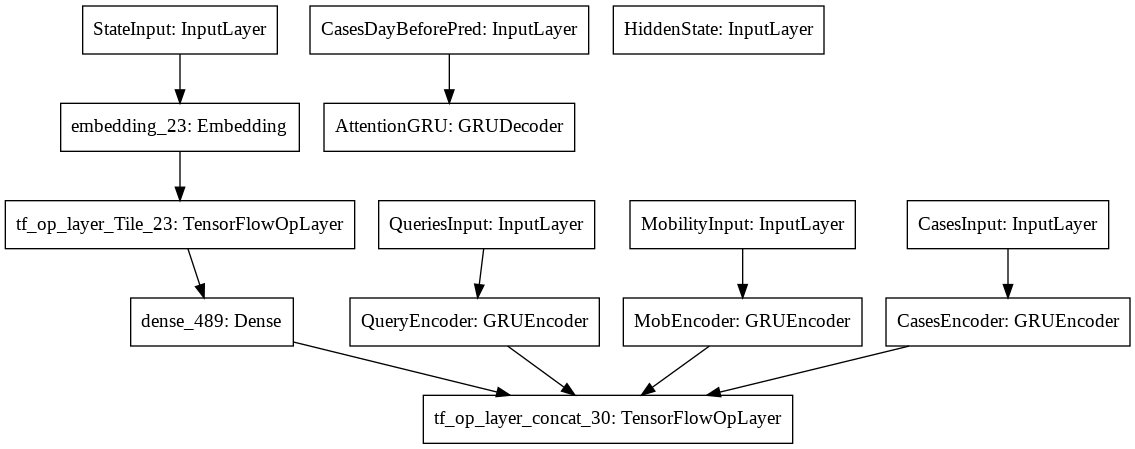

In [731]:
tf.keras.utils.plot_model(model_1)

**Large encoder** Define large decoder model here for the training loop

In [686]:
# Decoder model
encoded_output = layers.Input(shape=(enc_k, 512), name='EncodedOutput') #512 after concatenating all hiddens
decoded = decoder(final_cases_input, hidden_input, encoded_output, use_attention=True)
decoder_inputs = [final_cases_input, hidden_input, encoded_output]
decoder_model = models.Model(inputs=decoder_inputs, outputs=decoded, name="Decoder")
decoder_model.summary()

Model: "Decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CasesDayBeforePred (InputLayer) [(32, 1, 1)]         0                                            
__________________________________________________________________________________________________
EncodedOutput (InputLayer)      [(None, 7, 512)]     0                                            
__________________________________________________________________________________________________
HiddenState (InputLayer)        [(32, 512)]          0                                            
__________________________________________________________________________________________________
AttentionGRU (GRUDecoder)       ((32, 1), (32, 512), 5651330     CasesDayBeforePred[0][0]         
Total params: 5,651,330
Trainable params: 5,651,330
Non-trainable params: 0
________________

**State only decoder** Define the state-only decoder model here for the training loop. The reason we are creating a separate state decoder model is that the state gradient updates are not being propagated far enough to affect the state conditioning well. This applies a loss on the state only decoding directly.

In [687]:
# State decoder model
encoded_s_output = layers.Input(shape=(enc_k, embed_size), name='EncodedStateOutput')
state_decoded = state_decoder(final_cases_input, hidden_input_s, encoded_s_output, use_attention=True)

state_decoder_inputs = [final_cases_input, hidden_input_s, encoded_s_output]
state_decoder_model = models.Model(inputs=state_decoder_inputs, outputs=state_decoded, name="StateDecoder")
state_decoder_model.summary()

Model: "StateDecoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CasesDayBeforePred (InputLayer) [(32, 1, 1)]         0                                            
__________________________________________________________________________________________________
EncodedStateOutput (InputLayer) [(None, 7, 128)]     0                                            
__________________________________________________________________________________________________
StateOnlyHidden (InputLayer)    [(32, 128)]          0                                            
__________________________________________________________________________________________________
StateGRU (StateDecoder)         ((32, 1), (32, 128), 149250      CasesDayBeforePred[0][0]         
Total params: 149,250
Trainable params: 149,250
Non-trainable params: 0
_______________

# Ensemble

*WAS NOT AXED IN THE END DUE TO POOR PERFORMANCE. The model learned to exploit the fact that it could predict all 0's and achieve a very good MSE.* 

The last step is to ensemble the state-only decoder and the large decoder (state+queries+mobility). This allows the model to learn a weighting of responses from each weak classifier to arrive at a better prediction.

In [0]:
#===========
# Ensemble
#===========
pred_input_shape = 1
ensemble_input_1 = layers.Input(pred_input_shape)
ensemble_input_2 = layers.Input(pred_input_shape)
ensemble_1_weighted = layers.Dense(1, activation='relu', name='EnsembleW1')(ensemble_input_1)
ensemble_2_weighted = layers.Dense(1, activation='relu', name='EnsembleW2')(ensemble_input_2)
ensemble = ensemble_1_weighted + ensemble_2_weighted

# create model
ensemble_inputs = [ensemble_input_1, ensemble_input_2]
ensemble_model = models.Model(inputs=ensemble_inputs, outputs=ensemble, name='EnsembleModel')

In [689]:
ensemble_model.summary()

Model: "EnsembleModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_53 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
EnsembleW1 (Dense)              (None, 1)            2           input_52[0][0]                   
__________________________________________________________________________________________________
EnsembleW2 (Dense)              (None, 1)            2           input_53[0][0]                   
______________________________________________________________________________________

#Train

Use teacher forcing during training

In [0]:
# configs
max_length_decode = dec_k

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def MSLE(real, pred):
  loss_object = tf.keras.losses.MSLE
  loss_ = loss_object(real, pred)
  return tf.reduce_mean(loss_)

def MSE(real, pred):
  loss_object = tf.keras.losses.MSE
  loss_ = loss_object(real, pred)
  return tf.reduce_mean(loss_) 

In [0]:
# input will be the the previous days cases number
# targ will be the target cases

# for the first hidden state, use the concatenations of all last hidden state from the encoders

batch_size = batch_p

@tf.function
def train_step(q_e_input, m_e_input, c_e_input, state_input, final_cases_input, targ):

  loss_1 = 0
  # loss_2 = 0
  # loss_3 = 0

  with tf.GradientTape() as ensemble_tape,\
  tf.GradientTape() as large_tape,\
  tf.GradientTape() as state_tape:

    # initialize values
    encoder_output = encoder_model([q_e_input, m_e_input, c_e_input, state_input])
    dec_hidden = encoder_output[:,-1,:]
    dec_input = final_cases_input

    # initialize state specific values
    encoder_output_s = state_encoder_model([state_input])
    dec_hidden_s = encoder_output_s[:,-1,:]

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # Large ENCODER #####################
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder_model([dec_input, dec_hidden, encoder_output])
      loss_1 += MSLE(targ[:, t], predictions)
      
      # # State specific ENCODER ############
      # state_pred, dec_hidden_s, _ = state_decoder_model([dec_input, dec_hidden_s, encoder_output_s])
      # loss_2 += MSE(targ[:, t], state_pred)

      # # ENSEMBLE #############
      # ensemble_pred = ensemble_model([predictions, state_pred])
      # loss_3 += MSE(targ[:, t], ensemble_pred)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = loss_1 / int(targ.shape[1])

  # apply large dec gradient updates
  variables_1 = encoder_model.trainable_variables +\
   decoder_model.trainable_variables
  gradients_1 = large_tape.gradient(loss_1, variables_1)
  optimizer.apply_gradients(zip(gradients_1, variables_1))

  # # apply state dec gradient updates
  # variables_2 = state_encoder_model.trainable_variables +\
  #  state_decoder_model.trainable_variables
  # gradients_2 = state_tape.gradient(loss_2, variables_2)
  # optimizer.apply_gradients(zip(gradients_2, variables_2))

  # # apply ensemble gradient updates
  # variables_3 = ensemble_model.trainable_variables
  # gradients_3 = ensemble_tape.gradient(loss_3, variables_3)
  # optimizer.apply_gradients(zip(gradients_3, variables_3))

  return batch_loss

In [0]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder_model=encoder_model,
                                 decoder_model=decoder_model)

Review of inputs

*   **index 0 : Query encoder sequence INPUT**
*   index 1 : Query decoder sequence NOT USED
*   **index 2 : Mobility encoder sequence INPUT**
*   index 3 : Mobility decoder sequence NOT USED
*   **index 4 : Cases encoder sequence INPUT**
*   **index 5 : Cases encoder final output INPUT (to initialize decoder)**
* **index 6: State INPUT**  
* **index 7 : Cases decoder sequence TARGET**

In [694]:
epochs = 200
batch_size = batch_p
steps_per_epoch = len(train_indices)//batch_size

for epoch in range(epochs):
  start = time.time()

  total_loss = 0

  batch = 0
  for q_e_input, _, m_e_input, _, c_e_input, final_cases_input, state_input, targ in train_data:
    batch_loss = train_step(q_e_input, m_e_input, c_e_input, state_input, final_cases_input, targ)
    total_loss += batch_loss
    batch += 1

    if batch % 1000 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  # if (epoch + 1) % 2 == 0:
  #   checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 3.9132
Time taken for 1 epoch 27.749193906784058 sec

Epoch 2 Loss 1.7052
Time taken for 1 epoch 3.9745888710021973 sec

Epoch 3 Loss 1.1534
Time taken for 1 epoch 3.9570016860961914 sec

Epoch 4 Loss 0.8940
Time taken for 1 epoch 3.9356541633605957 sec

Epoch 5 Loss 0.7508
Time taken for 1 epoch 3.9092354774475098 sec

Epoch 6 Loss 0.6598
Time taken for 1 epoch 4.006421327590942 sec

Epoch 7 Loss 0.5735
Time taken for 1 epoch 3.8890933990478516 sec

Epoch 8 Loss 0.5014
Time taken for 1 epoch 3.962557554244995 sec

Epoch 9 Loss 0.4487
Time taken for 1 epoch 3.982584238052368 sec

Epoch 10 Loss 0.4260
Time taken for 1 epoch 3.884554386138916 sec

Epoch 11 Loss 0.4377
Time taken for 1 epoch 3.8401503562927246 sec

Epoch 12 Loss 0.3748
Time taken for 1 epoch 3.9008705615997314 sec

Epoch 13 Loss 0.3599
Time taken for 1 epoch 3.9757981300354004 sec

Epoch 14 Loss 0.3277
Time taken for 1 epoch 4.052273273468018 sec

Epoch 15 Loss 0.3071
Time taken for 1 epoch 4.002931356430054 

In [0]:
# manually save weights
# encoder_model.save_weights('../content/drive/My Drive/disease_encoder_20200510.h5')
# decoder_model.save_weights('../content/drive/My Drive/disease_decoder_20200510.h5')

In [0]:
# load weights if needed
# encoder_model.load_weights('../content/drive/My Drive/disease_encoder_20200508.h5')
# decoder_model.load_weights('../content/drive/My Drive/disease_decoder_20200508.h5')

#Evaluate

Evaluate using test_data on the following metrics:

* RMSE (total)
* RMSE (by state)





In [0]:
# greedy decoding for prediction

@tf.function
def evaluate_batch(q_e_input, m_e_input, c_e_input, state_input, final_cases_input, targ, flatten=True):
  """
  returns target as a vector of indices for each timestep (flattened).

  returns predictions as a tensor of probabilities 
  for each class for each timestep.

  returns attention_weights
  """
  max_length_targ = targ.shape[1]

  # initialize lists
  attention_plot = []
  predictions_list = []

  #initialize inputs into decoder
  encoder_output = encoder_model([q_e_input, m_e_input, c_e_input, state_input])
  dec_hidden = encoder_output[:,-1,:]
  dec_input = final_cases_input

  # initialize state specific values
  encoder_output_s = state_encoder_model([state_input])
  dec_hidden_s = encoder_output_s[:,-1,:]
  dec_input_s = final_cases_input

  for t in range(max_length_targ):

    # Large Decoder ####################
    predictions, dec_hidden, attention_weights = decoder_model([dec_input,
                                                         dec_hidden,
                                                         encoder_output])

    # storing the attention weights to plot later on
    attention_plot += [attention_weights]

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims(predictions, 1)

    # # State Decoder ###################
    # state_pred, dec_hidden_s, _ = state_decoder_model([dec_input_s, dec_hidden_s, encoder_output_s])
    # dec_input_s = tf.expand_dims(state_pred, 1)

    # # Ensemble #######################
    # predictions = ensemble_model([large_pred, state_pred])
    
    # predictions
    predictions_list += [tf.expand_dims(predictions, 1)]


  # make predictions_list into an array with shape (batch_size, time, 1)
  predictions_list = tf.concat(predictions_list, axis=1)

  if flatten == True:
    # flatten the predictions_list
    predictions_list = tf.reshape(predictions_list, (-1, 1))

    # flatten the target tensor
    targ = tf.keras.backend.flatten(targ)

  # make attention_plot into an array with shape(batch_size, time, encoder_hidden_size)
  attention_plot = tf.concat(attention_plot, axis=2)

  return targ, predictions_list, attention_plot

In [698]:
# collect target and predictions for test data
batch_size = batch_p

y_true = []
y_pred = [] # probabilities used for map

# set limits to number of batches you want to evaluate
limit_batches = 200 # Not enough RAM to do more
batch_count = 0

for q_e_input, _, m_e_input, _, c_e_input, final_cases_input, state_input, targ in test_data:
  if batch_count >= limit_batches:
    break
  
  targ, predictions_list, _ = evaluate_batch(q_e_input, m_e_input, c_e_input, state_input, final_cases_input, targ)

  # convert outputs to numpy
  targ = targ.numpy()
  predictions_list = predictions_list.numpy()

  # add to y_true, y_pred, y_pred_id
  y_true += [targ]
  y_pred += [predictions_list]
  
  batch_count += 1

  if batch_count % 20 == 0:
      print(f'Batch {batch_count} prediction done.')

# concat all batches * sample together
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

Batch 20 prediction done.
Batch 40 prediction done.
Batch 60 prediction done.
Batch 80 prediction done.


In [699]:
# Calculate MSE #################
print(f"Test RMSE: {np.mean(tf.keras.losses.MSE(y_true, y_pred))**0.5}")

Test RMSE: 24245.128170418073


In [700]:
max(y_true)

318134

In [701]:
max(y_pred)[0]

33037.887

The max for true cases is several orders of magnitude larger than the max of y_pred. We're seeing some large outliers, spikes here. This might be due to the total US count being at a different scale from the state level. Let's find RMSE at the state level.

In [0]:
def get_state_indices(state_df_list, state_abbrev_str):
  state_idx = state_vocab[state_abbrev_str]
  return [idx for idx, value in enumerate(state_df_list) if value[0] == state_idx]

def get_state_tups(queries_sequences, mobility_sequences, cases_sequences, state_df_list, state_abbrev_str):
  state_indices = get_state_indices(state_df_list, state_abbrev_str)
  return filter_seq(queries_sequences, mobility_sequences, cases_sequences, state_df_list, state_indices)

In [0]:
def evaluate_states(state_tups):
  state_data = tf.data.Dataset.from_tensor_slices(state_tups)
  batch_p = len(state_tups[0])
  state_data = state_data.batch(batch_p, drop_remainder=True)
  for q_e_input, _, m_e_input, _, c_e_input, final_cases_input, state_input, targ in state_data:
    d_target, d_pred, attn = evaluate_batch(q_e_input, m_e_input, c_e_input, state_input, final_cases_input, targ, flatten=False)
  return c_e_input, d_target, d_pred, attn

In [704]:
rmse_list = []
max_true = []
max_pred = []
min_true = []
min_pred = []
states = []
for state in state_list:
  tups = get_state_tups(queries_sequences, mobility_sequences, cases_sequences, state_df_list, state)
  e, target, predictions, attention_plots= evaluate_states(tups)
  target = np.array(target).flatten()
  predictions = np.array(predictions).flatten()
  rmse_list += [np.mean(tf.keras.losses.MSE(target, predictions))**0.5]
  max_true += [np.max(target)]
  max_pred += [int(np.max(predictions))]
  min_true += [np.min(target)]
  min_pred += [int(np.min(predictions))]
  states += [state]

display_df = pd.DataFrame({'state': states,\
              'rmse': rmse_list,\
              'max_true': max_true,\
              'max_pred': max_pred,\
              'min_true': min_true,\
              'min_pred': min_pred})
display_df.sort_values(by='rmse', ascending=True)

,state,rmse,max_true,max_pred,min_true,min_pred
21,MT,20.733586,454,464,0,0
44,HI,25.681209,611,624,0,0
38,WY,29.614746,579,563,0,0
26,AK,41.477401,363,464,0,0
13,ND,44.263770,1153,1219,0,0
43,ME,52.329497,1152,1275,0,0
6,WV,53.266120,1184,1264,0,0
18,VT,54.347825,886,1124,0,0
45,NH,178.466476,2429,2581,0,0
20,UT,200.603718,4981,4548,0,0


# Plot examples


*   **True vs. Prediction:** We will take a few states. Plot each window of their trajectory and plot out their predictions against their true values in the look-forward period.
*   **Attention**: We will make some attention plots for a few sample sequences, to see where the decoder is paying attention to.

Let's use TN, MA, NY and WA. Since those tended to be hard hit areas.



In [0]:
TN_tups = get_state_tups(queries_sequences, mobility_sequences, cases_sequences, state_df_list, 'TN')

In [0]:
MA_tups = get_state_tups(queries_sequences, mobility_sequences, cases_sequences, state_df_list, 'MA')

In [0]:
NY_tups = get_state_tups(queries_sequences, mobility_sequences, cases_sequences, state_df_list, 'NY')

In [0]:
WA_tups = get_state_tups(queries_sequences, mobility_sequences, cases_sequences, state_df_list, 'WA')

In [0]:
tn_e, tn_target, tn_predictions, tn_attention_plots = evaluate_states(TN_tups)
ma_e, ma_target, ma_predictions, ma_attention_plots = evaluate_states(MA_tups)
ny_e, ny_target, ny_predictions, ny_attention_plots = evaluate_states(NY_tups)
wa_e, wa_target, wa_predictions, wa_attention_plots = evaluate_states(WA_tups)

In [0]:
def build_plot_df(c_e_input, target, pred, windows_list):
  # concatenate cases encode and cases decode (target)
  # to get full window cases
  c_e_input = tf.squeeze(c_e_input, axis=-1)
  target = tf.squeeze(target, axis=-1)
  true_cases = tf.concat([c_e_input, target], axis=1).numpy()

  # concatenate preds
  pred_lookback = np.full([69, 7], np.nan)
  pred = tf.squeeze(pred, axis=-1).numpy()
  pred_cases = np.concatenate([pred_lookback, pred], axis=1)

  # concatenate encoding and decoding window integers
  time_steps = np.concatenate([np.concatenate(i, 0) for i in windows_list], axis=0)

  # window idx
  window_idx = []
  for idx, window in enumerate(windows_list):
    for steps in range(0, enc_k+dec_k):
      window_idx += [idx]

  plot_dict = {'target': true_cases.flatten(),\
               'pred': pred_cases.flatten(),\
               'time_steps': time_steps,\
               'window': window_idx
               }
  df = pd.DataFrame.from_dict(plot_dict)
  return df

In [0]:
tn_plot_df = build_plot_df(tn_e, tn_target, tn_predictions, windows_list)
ma_plot_df = build_plot_df(ma_e, ma_target, ma_predictions, windows_list)
ny_plot_df = build_plot_df(ny_e, ny_target, ny_predictions, windows_list)
wa_plot_df = build_plot_df(wa_e, wa_target, wa_predictions, windows_list)

TN predictions given 7-day look-back and 3-day look-forward
GREY:true, BLUE:prediction


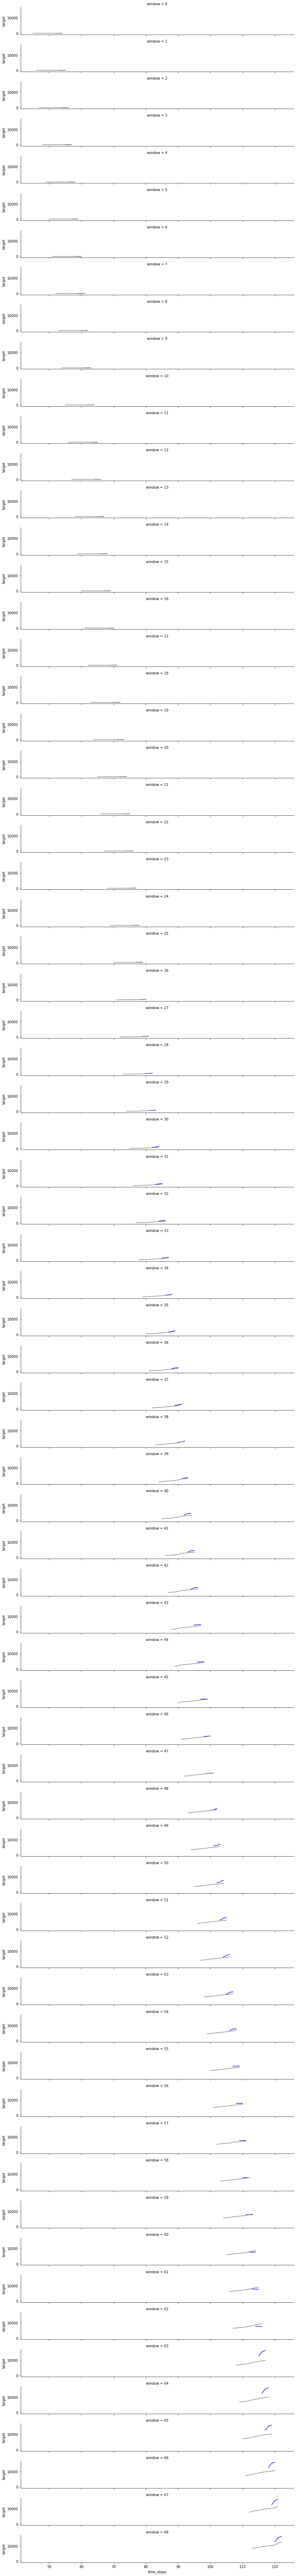

In [720]:
# TN predictions plot
import matplotlib.pyplot as plt
import seaborn as sns

print('TN predictions given 7-day look-back and 3-day look-forward\nGREY:true, BLUE:prediction')
g = sns.FacetGrid(tn_plot_df, row="window", height=1.5, aspect=8, sharex=True)
g = g.map(plt.plot, "time_steps", "pred", color='blue')
g = g.map(plt.plot, "time_steps", "target", color='gray');

WA predictions given 7-day look-back and 3-day look-forward
GREY:true, BLUE:prediction


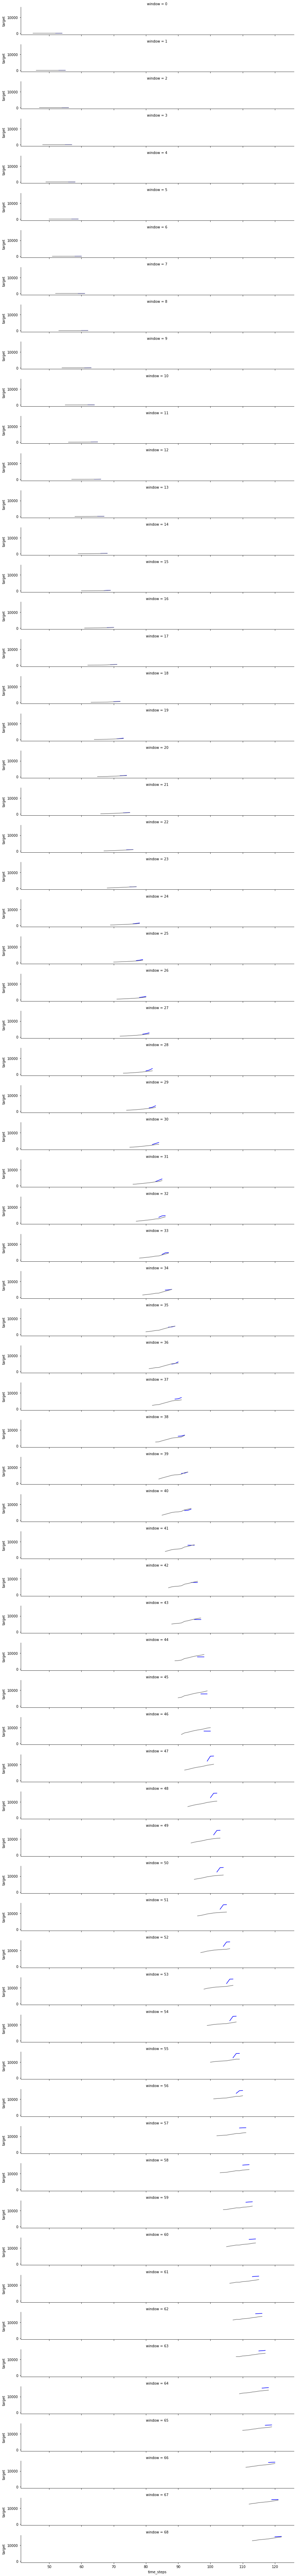

In [714]:
# WA predictions plot
import matplotlib.pyplot as plt
import seaborn as sns

print('WA predictions given 7-day look-back and 3-day look-forward\nGREY:true, BLUE:prediction')
g = sns.FacetGrid(wa_plot_df, row="window", height=1.5, aspect=8, sharex=True)
g = g.map(plt.plot, "time_steps", "pred", color='blue')
g = g.map(plt.plot, "time_steps", "target", color='gray');

NY predictions given 7-day look-back and 3-day look-forward
GREY:true, BLUE:prediction


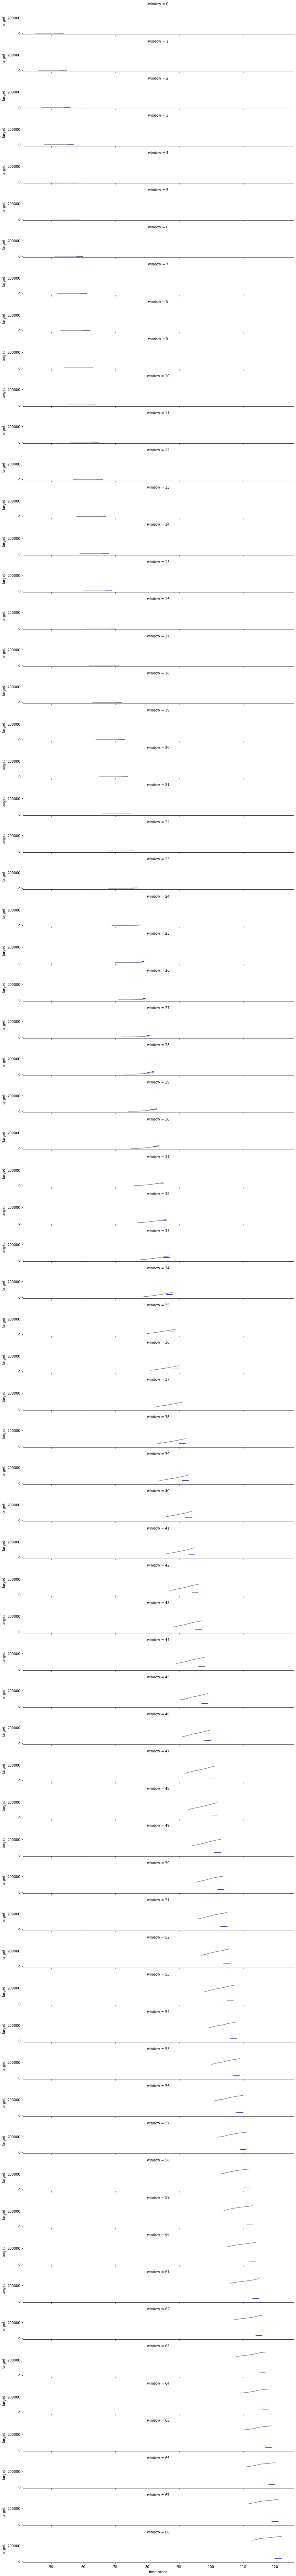

In [713]:
# NY predictions plot
import matplotlib.pyplot as plt
import seaborn as sns

print('NY predictions given 7-day look-back and 3-day look-forward\nGREY:true, BLUE:prediction')
g = sns.FacetGrid(ny_plot_df, row="window", height=1.5, aspect=8, sharex=True)
g = g.map(plt.plot, "time_steps", "pred", color='blue')
g = g.map(plt.plot, "time_steps", "target", color='gray');

MA predictions given 7-day look-back and 3-day look-forward
GREY:true, BLUE:prediction


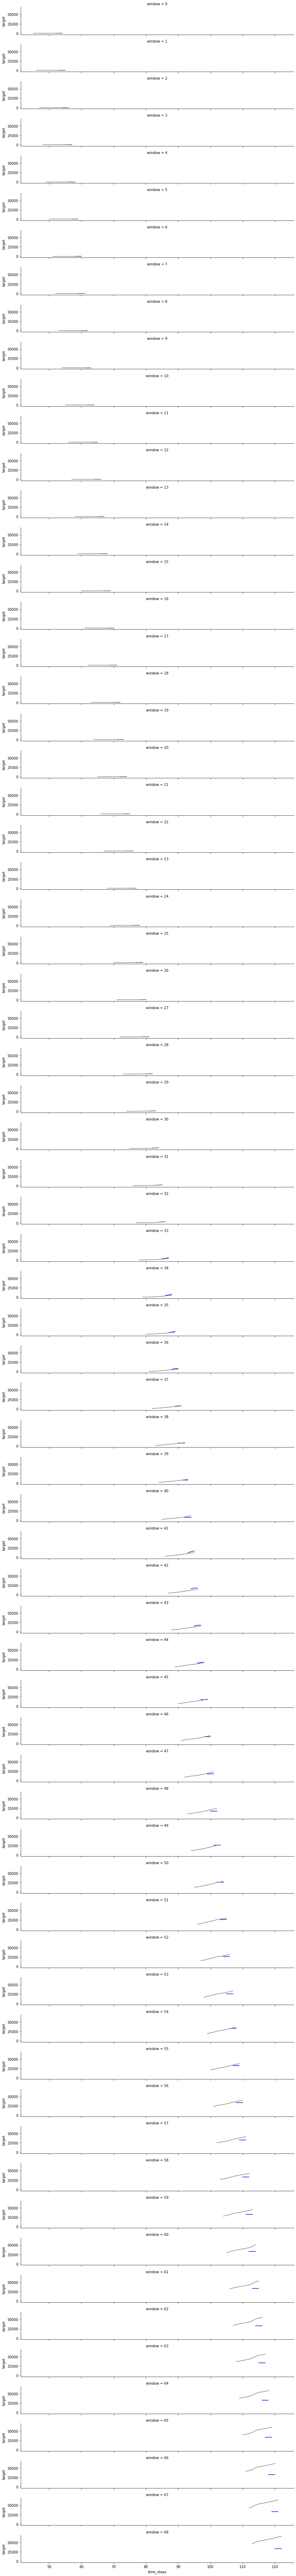

In [712]:
# MA predictions plot
import matplotlib.pyplot as plt
import seaborn as sns

print('MA predictions given 7-day look-back and 3-day look-forward\nGREY:true, BLUE:prediction')
g = sns.FacetGrid(ma_plot_df, row="window", height=1.5, aspect=8, sharex=True)
g = g.map(plt.plot, "time_steps", "pred", color='blue')
g = g.map(plt.plot, "time_steps", "target", color='gray');

## Attention plots

This is used to asssess what timestep the decoder is paying attention to. Let's use TN as an example.

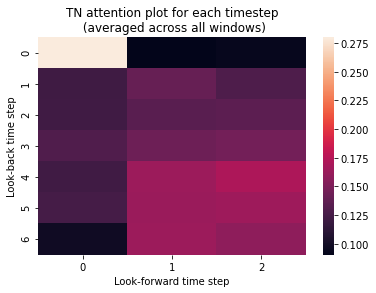

In [742]:
import seaborn as sns

sns.heatmap(np.mean(tn_attention_plots, axis=0))
plt.title("TN attention plot for each timestep\n (averaged across all windows)")
plt.xlabel("Look-forward time step")
plt.ylabel("Look-back time step");

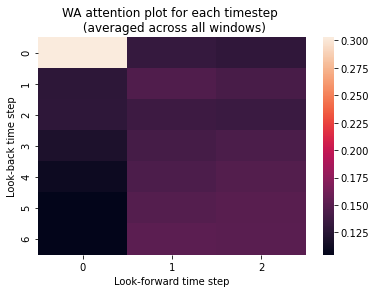

In [743]:
sns.heatmap(np.mean(wa_attention_plots, axis=0))
plt.title("WA attention plot for each timestep \n (averaged across all windows)")
plt.xlabel("Look-forward time step")
plt.ylabel("Look-back time step");

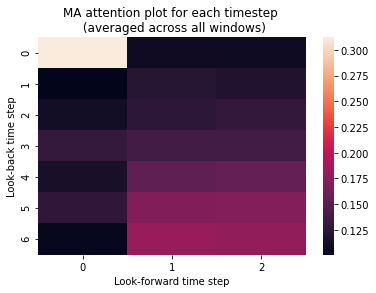

In [744]:
sns.heatmap(np.mean(ma_attention_plots, axis=0))
plt.title("MA attention plot for each timestep \n (averaged across all windows)")
plt.xlabel("Look-forward time step")
plt.ylabel("Look-back time step");

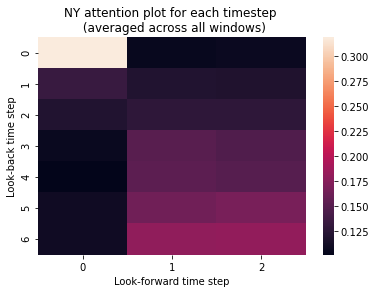

In [745]:
sns.heatmap(np.mean(ny_attention_plots, axis=0))
plt.title("NY attention plot for each timestep \n (averaged across all windows)")
plt.xlabel("Look-forward time step")
plt.ylabel("Look-back time step");